<a href="https://colab.research.google.com/github/Jackyjz/APS360_Project/blob/main/360_Soccer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install YOLO stuff

# 1) Remove any mismatched torch
!pip uninstall -y torch torchvision torchaudio

# 2) Install the Colab GPU-compatible build (CUDA 11.8)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# 3) Reinstall ultralytics & friends
!pip install ultralytics roboflow pillow

Found existing installation: torch 2.7.1+cu118
Uninstalling torch-2.7.1+cu118:
  Successfully uninstalled torch-2.7.1+cu118
Found existing installation: torchvision 0.22.1+cu118
Uninstalling torchvision-0.22.1+cu118:
  Successfully uninstalled torchvision-0.22.1+cu118
Found existing installation: torchaudio 2.7.1+cu118
Uninstalling torchaudio-2.7.1+cu118:
  Successfully uninstalled torchaudio-2.7.1+cu118
Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.7.1%2Bcu118-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (28 kB)
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.22.1%2Bcu118-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.7.1%2Bcu118-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.6 kB)
Using cached https://download.pytorch.org/whl/cu118/torch-2.7.1%2Bcu118-cp311-cp311-manylinux_2_28_x86_64.whl (905.3 MB)
Using cache

In [ ]:
from pathlib import Path
from ultralytics import YOLO
from PIL import Image

ModuleNotFoundError: No module named 'ultralytics'

In [ ]:
import torch
import pickle
from pathlib import Path
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

In [ ]:
class Last16FramesDataset(Dataset):
    def __init__(self, root_dir, class_map,
                 cache_file=None,
                 transform=None):
        self.root = Path(root_dir)
        self.class_map = class_map
        self.transform = transform or transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
        ])

        # Try loading from cache
        if cache_file and Path(cache_file).exists():
            print("Loading samples from cache:", cache_file)
            with open(cache_file, 'rb') as f:
                self.samples = pickle.load(f)

        else:
            print("Scanning folders to build samples list …")
            self.samples = []
            temp = {}
            for class_folder in self.root.iterdir():
                if not class_folder.is_dir(): continue
                lbl = class_map[class_folder.name]
                for video_folder in class_folder.iterdir():
                    if not video_folder.is_dir(): continue
                    key = (class_folder.name, video_folder.name)
                    temp.setdefault(key, []).extend(
                        sorted([p for p in video_folder.iterdir() if p.is_dir()],
                               key=lambda p: int(p.name))
                    )
            for (cls_name, vid_name), frames in temp.items():
                keep = frames[-16:] if len(frames) >= 16 else frames
                # only keep frames with both crops
                keep = [f for f in keep
                        if (f/'kicker.jpg').exists() and (f/'goalie.jpg').exists()]
                if keep:
                    self.samples.append((keep, class_map[cls_name]))
            # Save cache
            if cache_file:
                print("Saving cache to:", cache_file)
                with open(cache_file, 'wb') as f:
                    pickle.dump(self.samples, f)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frame_dirs, label = self.samples[idx]           # up to 16 folders
        N = len(frame_dirs)                    # actual frame count

        # Load and transform, grouping into (N, 2, 3, 224, 224)
        crops = []
        for fd in frame_dirs:
            for obj in ('kicker.jpg', 'goalie.jpg'):
                img = Image.open(fd/obj).convert('RGB')
                crops.append(self.transform(img))      # each is (3,224,224)

        crops = torch.stack(crops)                # (N*2, 3,224,224)
        crops = crops.view(N, 2, 3, 224, 224)         # (N, 2, 3,224,224)

        return crops, N, label

In [ ]:
!ls /content/drive/MyDrive/


In [ ]:
!unzip -q "/content/drive/MyDrive/cropped.zip" -d "/content/full_dataset"


In [ ]:
from pathlib import Path
import pickle

CLASS_MAP = {'xx1':0, 'xx0':1, '1xx':2, '0xx':3, 'x1x':4, 'x0x':5}

dataset = Last16FramesDataset(
    root_dir=Path("/content/full_dataset/cropped"),
    class_map=CLASS_MAP,
    cache_file=Path("/content/last16_samples.pkl")  # Or point to .pkl in Drive if needed
)
print(f"✅ Loaded {len(dataset)} samples.")

Scanning folders to build samples list …
Saving cache to: /content/last16_samples.pkl
✅ Loaded 783 samples.


In [ ]:
# Create Loaders
from torch.utils.data import random_split, DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    # batch is a list of (crops, N, label)
    crops_list, lengths, labels = zip(*batch)
    # crops_list[i]: Tensor shape (Ni,2,3,224,224)

    # 1) pad along the time axis (dim=0)
    # pad_sequence expects a list of (Ti, *) tensors and pads dim=0 to max(Ti)
    padded = pad_sequence(crops_list, batch_first=True)
    # padded.shape == (B, max_N, 2, 3, 224,224)

    lengths = torch.tensor(lengths, dtype=torch.long)
    labels  = torch.tensor(labels, dtype=torch.long)
    return padded, lengths, labels

# 1) Split 70% train, 20% val, 10% test
total = len(dataset)
train_n = int(0.7 * total)
val_n = int(0.2 * total)
test_n = total - train_n - val_n

# 2) Split into 3 subsets
train_ds, val_ds, test_ds = random_split(dataset, [train_n, val_n, test_n])

# 3) Wrap each in a DataLoader (can adjust batch size / num_workers)
batch_size = 4 #changed
num_workers = 4

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=True
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# check
crops, lengths, labels = next(iter(train_loader))
print("crops:", crops.shape)          # expect (B, T_max, 2, 3, 224, 224)
print("lengths:", lengths.shape, lengths)   # (B,) with values ≤ T_max
print("labels:", labels.shape, labels)     # (B,)

crops: torch.Size([4, 16, 2, 3, 224, 224])
lengths: torch.Size([4]) tensor([ 9, 16, 16, 16])
labels: torch.Size([4]) tensor([0, 2, 3, 3])


# **Model**

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

class PenaltyModel(nn.Module):
    def __init__(self, feat_dim=512, lstm_hidden=256, num_classes=6,dropout_prob = 0.4):
        super().__init__()
        # 1) Pretrained ResNet-18 backbone (drop final FC)
        base = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(base.children())[:-1])  # → (B, feat_dim,1,1)

        # 2) Single-layer LSTM over the time dimension
        #    Input size = 2×feat_dim (kicker+goalie), hidden size = lstm_hidden
        self.lstm = nn.LSTM(
            input_size=2*feat_dim,
            hidden_size=lstm_hidden,
            num_layers=1,
            dropout = dropout_prob, #LSTM internal dropout
            # bidirectional=True,
            batch_first=True
        )

        self.dropout = nn.Dropout(p=dropout_prob)


        # 3) Final linear head
        self.fc = nn.Linear(lstm_hidden, num_classes)

    def forward(self, crops, lengths):
        B, T_max, num_objs, C, H, W = crops.shape  # should be (B, T_max, 2, 3, 224, 224)

        # 1) run each crop through ResNet
        x = crops.view(B * T_max * num_objs, C, H, W)        # → (B*T*2, 3, 224, 224)
        f = self.backbone(x).view(B, T_max, num_objs, -1)    # → (B, T_max, 2, feat_dim)

        # 2) concat kicker + goalie features → (B, T_max, 2*feat_dim)
        f = f.view(B, T_max, -1)

        # 3) pack and run through LSTM
        packed = pack_padded_sequence(f, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (h, _) = self.lstm(packed)

        # 4) Apply External dropout and classify from final LSTM hidden state

        # Concatenate the forward and backward hidden states

        #bidirection
        # out = torch.cat((h[-2], h[-1]), dim=1)  # → (B, 2*lstm_hidden)
        # out = self.dropout(out)
        # return self.fc(out)

        #notbidirectional
        out = h[-1]                  # shape (B, lstm_hidden)
        out = self.dropout(out)
        return self.fc(out)

# **Train**

**Balance Data Set**

In [ ]:
import torch

# Class counts from your dataset
class_counts = torch.tensor([224, 96, 280, 101, 76, 19], dtype=torch.float)

# Inverse frequency (to give more weight to smaller classes)
class_weights = 1.0 / class_counts

# Normalize weights to sum to number of classes (optional)
class_weights = class_weights * (len(class_counts) / class_weights.sum())

print(class_weights)


tensor([0.2845, 0.6639, 0.2276, 0.6310, 0.8386, 3.3544])


In [ ]:
import torch
import matplotlib.pyplot as plt

def train(model, train_loader, val_loader, device, num_epochs=20, lr=1e-4, weight_decay=1e-2):
    """
    Args:
        model (nn.Module): your CNN+LSTM model
        train_loader (DataLoader): DataLoader for training set
        val_loader   (DataLoader): DataLoader for validation set
        device       (torch.device): 'cuda' or 'cpu'
        num_epochs   (int): number of epochs
        lr           (float): learning rate
        weight_decay (float): weight decay for AdamW
    """
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device)) #balancing class
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0.0
    best_model_state = None
    for epoch in range(1, num_epochs+1):
        # ---- Training ----
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for crops, lengths, labels in train_loader:
            crops, lengths, labels = (
                crops.to(device),
                lengths.to(device),
                labels.to(device)
            )
            optimizer.zero_grad()
            outputs = model(crops, lengths)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_losses.append(running_loss / total)
        train_accs.append(correct / total)

        # ---- Validation ----
        model.eval()
        v_loss, v_correct, v_total = 0.0, 0, 0
        with torch.no_grad():
            for crops, lengths, labels in val_loader:
                crops, lengths, labels = (
                    crops.to(device),
                    lengths.to(device),
                    labels.to(device)
                )
                outputs = model(crops, lengths)
                loss = criterion(outputs, labels)

                v_loss += loss.item() * labels.size(0)
                preds = outputs.argmax(dim=1)
                v_correct += (preds == labels).sum().item()
                v_total += labels.size(0)

        val_losses.append(v_loss / v_total)
        val_accs.append(v_correct / v_total)

        # ✅ Save best model AFTER validation
        if val_accs[-1] > best_val_acc:
            best_val_acc = val_accs[-1]
            best_model_state = model.state_dict()
            torch.save(best_model_state, "best_penalty_model.pt")
            print("✅ Saved best model to best_penalty_model.pt")

        print(f"Epoch {epoch}/{num_epochs} | "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f} | "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")

    # ---- Plot Loss ----
    plt.figure()
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title('Train vs. Validation Loss')
    plt.legend()
    plt.show()

    # ---- Plot Accuracy ----
    plt.figure()
    plt.plot(range(1, num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, num_epochs+1), val_accs, label='Val Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title('Train vs. Validation Accuracy')
    plt.legend()
    plt.show()

✅ Saved best model to best_penalty_model.pt
Epoch 1/50 | Train Loss: 1.5647, Train Acc: 0.3686 | Val Loss: 1.4907, Val Acc: 0.3974
✅ Saved best model to best_penalty_model.pt
Epoch 2/50 | Train Loss: 1.1571, Train Acc: 0.5894 | Val Loss: 1.6508, Val Acc: 0.4038
✅ Saved best model to best_penalty_model.pt
Epoch 3/50 | Train Loss: 0.6610, Train Acc: 0.8175 | Val Loss: 1.4760, Val Acc: 0.4359
Epoch 4/50 | Train Loss: 0.2754, Train Acc: 0.9507 | Val Loss: 1.7143, Val Acc: 0.4167
✅ Saved best model to best_penalty_model.pt
Epoch 5/50 | Train Loss: 0.0898, Train Acc: 0.9927 | Val Loss: 1.6625, Val Acc: 0.4423
✅ Saved best model to best_penalty_model.pt
Epoch 6/50 | Train Loss: 0.0315, Train Acc: 1.0000 | Val Loss: 1.5528, Val Acc: 0.4487
Epoch 7/50 | Train Loss: 0.0176, Train Acc: 1.0000 | Val Loss: 1.6582, Val Acc: 0.4295
✅ Saved best model to best_penalty_model.pt
Epoch 8/50 | Train Loss: 0.0125, Train Acc: 1.0000 | Val Loss: 1.6723, Val Acc: 0.4679
Epoch 9/50 | Train Loss: 0.0105, Train A

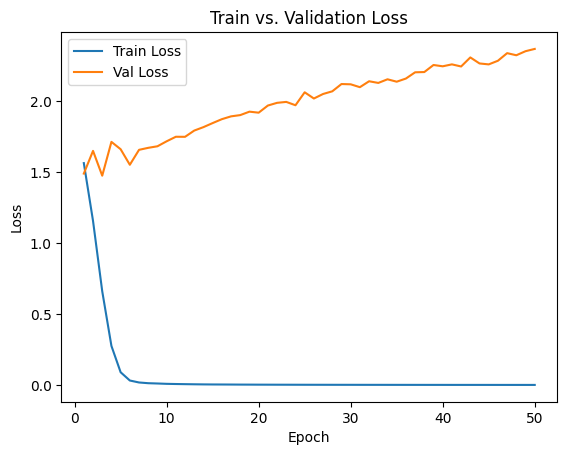

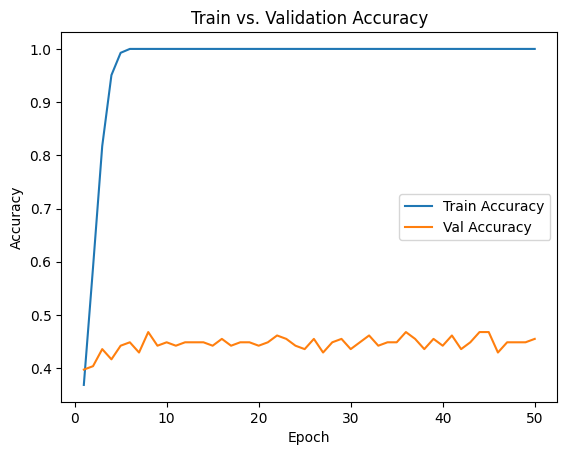

In [ ]:
# train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use GPU if available

model = PenaltyModel()   # can customize different hidden sizes / number of classes
model = model.to(device)  # use GPU
train(model, train_loader, val_loader, device, num_epochs=50)

✅ Saved best model to best_penalty_model.pt
Epoch 1/50 | Train Loss: 1.6549, Train Acc: 0.3613 | Val Loss: 1.5118, Val Acc: 0.3718
✅ Saved best model to best_penalty_model.pt
Epoch 2/50 | Train Loss: 1.4745, Train Acc: 0.4252 | Val Loss: 1.5518, Val Acc: 0.3782
Epoch 3/50 | Train Loss: 1.4522, Train Acc: 0.4416 | Val Loss: 1.5677, Val Acc: 0.3782
✅ Saved best model to best_penalty_model.pt
Epoch 4/50 | Train Loss: 1.4554, Train Acc: 0.4416 | Val Loss: 1.4600, Val Acc: 0.4167
Epoch 5/50 | Train Loss: 1.3419, Train Acc: 0.4964 | Val Loss: 1.6538, Val Acc: 0.3590
Epoch 6/50 | Train Loss: 1.3384, Train Acc: 0.5182 | Val Loss: 1.6282, Val Acc: 0.3782
✅ Saved best model to best_penalty_model.pt
Epoch 7/50 | Train Loss: 1.3186, Train Acc: 0.5091 | Val Loss: 1.4808, Val Acc: 0.4359
✅ Saved best model to best_penalty_model.pt
Epoch 8/50 | Train Loss: 1.3010, Train Acc: 0.5292 | Val Loss: 1.4265, Val Acc: 0.4808
✅ Saved best model to best_penalty_model.pt
Epoch 9/50 | Train Loss: 1.2331, Train A

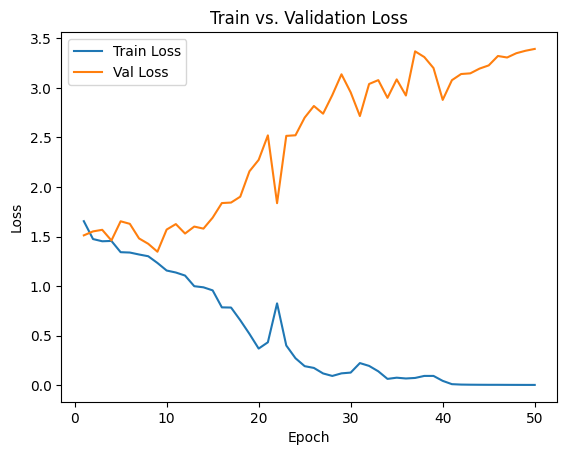

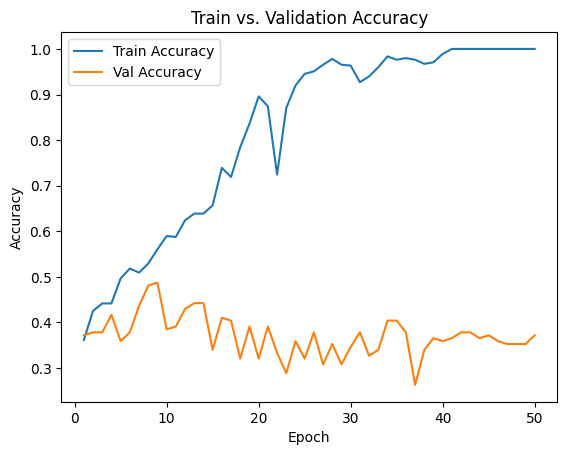

In [ ]:
train(model, train_loader, val_loader, device,lr=0.001, num_epochs=50)

✅ Saved best model to best_penalty_model.pt
Epoch 1/50 | Train Loss: 1.8001, Train Acc: 0.2172 | Val Loss: 1.8520, Val Acc: 0.2628
✅ Saved best model to best_penalty_model.pt
Epoch 2/50 | Train Loss: 1.7654, Train Acc: 0.2609 | Val Loss: 1.7896, Val Acc: 0.2885
Epoch 3/50 | Train Loss: 1.7214, Train Acc: 0.3139 | Val Loss: 1.7695, Val Acc: 0.1923
✅ Saved best model to best_penalty_model.pt
Epoch 4/50 | Train Loss: 1.7518, Train Acc: 0.2500 | Val Loss: 1.7171, Val Acc: 0.3846
✅ Saved best model to best_penalty_model.pt
Epoch 5/50 | Train Loss: 1.6775, Train Acc: 0.3358 | Val Loss: 1.7176, Val Acc: 0.4038
Epoch 6/50 | Train Loss: 1.6410, Train Acc: 0.3339 | Val Loss: 1.6748, Val Acc: 0.3910
Epoch 7/50 | Train Loss: 1.6562, Train Acc: 0.3047 | Val Loss: 1.6323, Val Acc: 0.4038
Epoch 8/50 | Train Loss: 1.5842, Train Acc: 0.3577 | Val Loss: 1.7031, Val Acc: 0.3013
Epoch 9/50 | Train Loss: 1.5173, Train Acc: 0.3850 | Val Loss: 1.6862, Val Acc: 0.3654
Epoch 10/50 | Train Loss: 1.5359, Train A

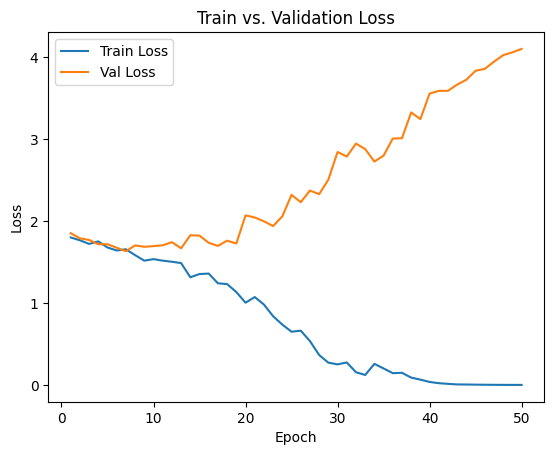

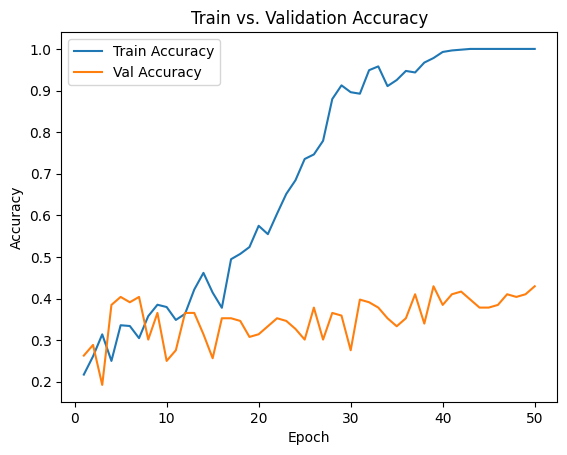

In [ ]:
# train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use GPU if available

model = PenaltyModel()   # can customize different hidden sizes / number of classes
model = model.to(device)  # use GPU
train(model, train_loader, val_loader, device,lr=0.0005, num_epochs=50)

# **Best on so far**

✅ Saved best model to best_penalty_model.pt
Epoch 1/50 | Train Loss: 1.7981, Train Acc: 0.2445 | Val Loss: 1.7592, Val Acc: 0.2436
✅ Saved best model to best_penalty_model.pt
Epoch 2/50 | Train Loss: 1.6202, Train Acc: 0.3850 | Val Loss: 1.7221, Val Acc: 0.3782
✅ Saved best model to best_penalty_model.pt
Epoch 3/50 | Train Loss: 1.4008, Train Acc: 0.5547 | Val Loss: 1.6692, Val Acc: 0.3910
✅ Saved best model to best_penalty_model.pt
Epoch 4/50 | Train Loss: 1.1465, Train Acc: 0.6861 | Val Loss: 1.6877, Val Acc: 0.4679
Epoch 5/50 | Train Loss: 0.8352, Train Acc: 0.8084 | Val Loss: 1.6916, Val Acc: 0.3910
Epoch 6/50 | Train Loss: 0.5245, Train Acc: 0.9307 | Val Loss: 1.8070, Val Acc: 0.3910
Epoch 7/50 | Train Loss: 0.3018, Train Acc: 0.9799 | Val Loss: 1.8924, Val Acc: 0.4359
✅ Saved best model to best_penalty_model.pt
Epoch 8/50 | Train Loss: 0.1869, Train Acc: 0.9945 | Val Loss: 1.9563, Val Acc: 0.5256
Epoch 9/50 | Train Loss: 0.1286, Train Acc: 0.9964 | Val Loss: 2.0080, Val Acc: 0.48

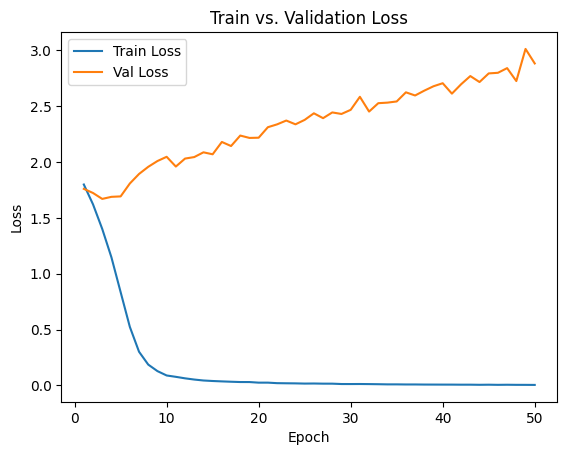

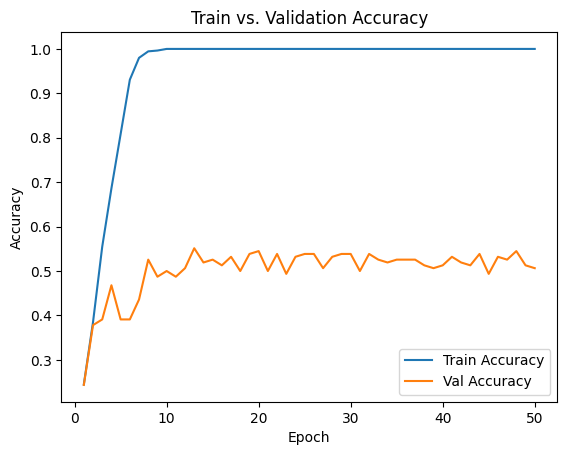

In [ ]:
# train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use GPU if available

model = PenaltyModel()   # can customize different hidden sizes / number of classes
model = model.to(device)  # use GPU
train(model, train_loader, val_loader, device,lr=1e-4, num_epochs=50)

# **this time i added internal dropout and cange lr to 1e-3 and batch size to 4**

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


✅ Saved best model to best_penalty_model.pt
Epoch 1/50 | Train Loss: 1.8038, Train Acc: 0.2044 | Val Loss: 1.7530, Val Acc: 0.2756
✅ Saved best model to best_penalty_model.pt
Epoch 2/50 | Train Loss: 1.7704, Train Acc: 0.2901 | Val Loss: 1.7406, Val Acc: 0.3782
Epoch 3/50 | Train Loss: 1.7652, Train Acc: 0.2445 | Val Loss: 1.7622, Val Acc: 0.3590
Epoch 4/50 | Train Loss: 1.7775, Train Acc: 0.2719 | Val Loss: 1.7448, Val Acc: 0.3590
Epoch 5/50 | Train Loss: 1.7772, Train Acc: 0.2920 | Val Loss: 1.7415, Val Acc: 0.2821
Epoch 6/50 | Train Loss: 1.7580, Train Acc: 0.2737 | Val Loss: 1.7424, Val Acc: 0.3590
Epoch 7/50 | Train Loss: 1.7665, Train Acc: 0.3066 | Val Loss: 1.7457, Val Acc: 0.3590
Epoch 8/50 | Train Loss: 1.7654, Train Acc: 0.2920 | Val Loss: 1.7372, Val Acc: 0.3077
Epoch 9/50 | Train Loss: 1.7468, Train Acc: 0.2847 | Val Loss: 1.7414, Val Acc: 0.3590
Epoch 10/50 | Train Loss: 1.7464, Train Acc: 0.2810 | Val Loss: 1.7382, Val Acc: 0.3013
Epoch 11/50 | Train Loss: 1.7519, Train A

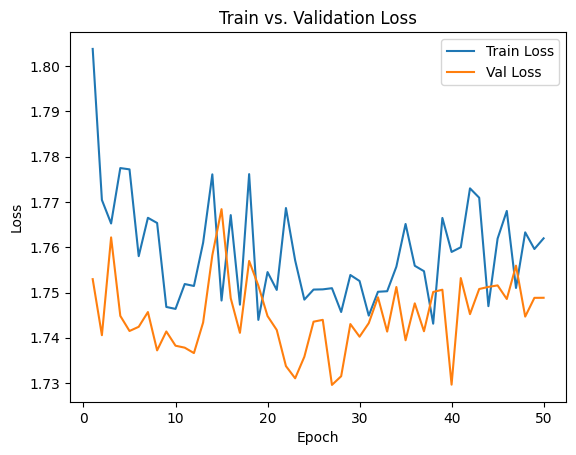

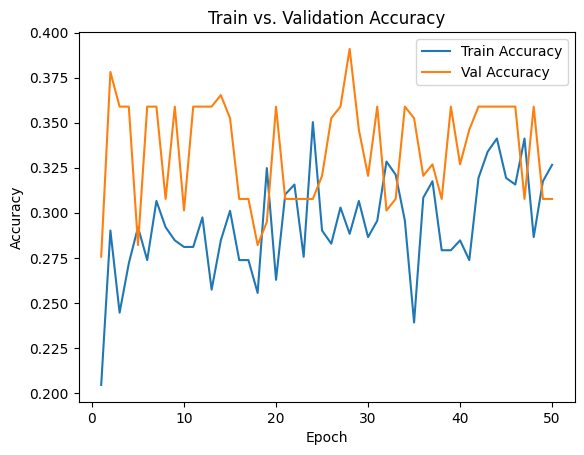

In [ ]:
  # train
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use GPU if available

  model = PenaltyModel()   # can customize different hidden sizes / number of classes
  model = model.to(device)  # use GPU
  train(model, train_loader, val_loader, device,lr=1e-3, num_epochs=50)

✅ Saved best model to best_penalty_model.pt
Epoch 1/100 | Train Loss: 1.7806, Train Acc: 0.2391 | Val Loss: 1.7297, Val Acc: 0.3397
Epoch 2/100 | Train Loss: 1.7715, Train Acc: 0.3047 | Val Loss: 1.7913, Val Acc: 0.1218
✅ Saved best model to best_penalty_model.pt
Epoch 3/100 | Train Loss: 1.7792, Train Acc: 0.2281 | Val Loss: 1.7340, Val Acc: 0.3782
Epoch 4/100 | Train Loss: 1.7658, Train Acc: 0.2737 | Val Loss: 1.7406, Val Acc: 0.3654
Epoch 5/100 | Train Loss: 1.7487, Train Acc: 0.3248 | Val Loss: 1.7513, Val Acc: 0.3590
Epoch 6/100 | Train Loss: 1.7622, Train Acc: 0.2810 | Val Loss: 1.7583, Val Acc: 0.3141
Epoch 7/100 | Train Loss: 1.7614, Train Acc: 0.2500 | Val Loss: 1.7514, Val Acc: 0.3077
Epoch 8/100 | Train Loss: 1.7592, Train Acc: 0.3011 | Val Loss: 1.7466, Val Acc: 0.3077
Epoch 9/100 | Train Loss: 1.7482, Train Acc: 0.2555 | Val Loss: 1.7337, Val Acc: 0.3077
Epoch 10/100 | Train Loss: 1.7608, Train Acc: 0.3066 | Val Loss: 1.7418, Val Acc: 0.3590
Epoch 11/100 | Train Loss: 1.75

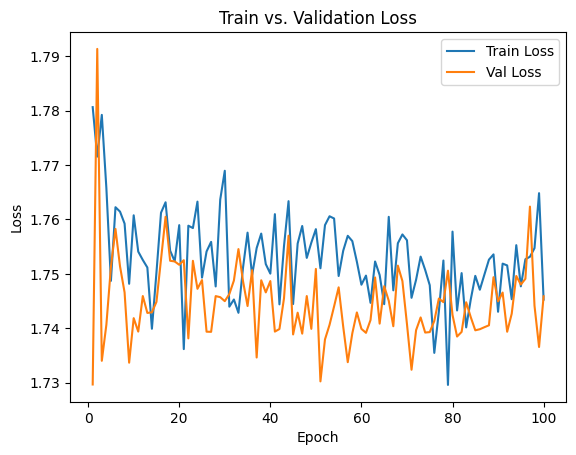

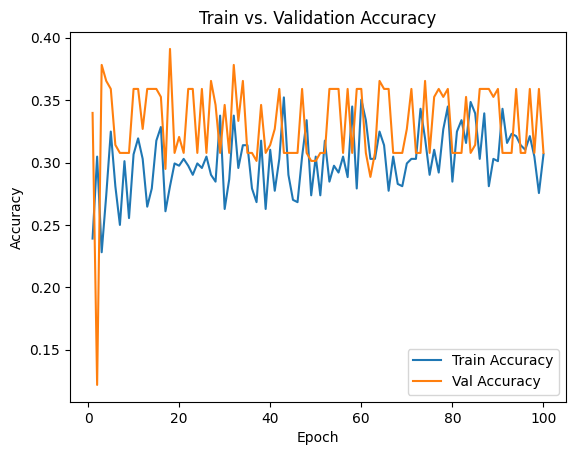

In [ ]:
# train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use GPU if available

model = PenaltyModel()   # can customize different hidden sizes / number of classes
model = model.to(device)  # use GPU
train(model, train_loader, val_loader, device,lr=1e-3, num_epochs=100)

# **Try WeightedRandomSampler**

✅ Saved best model to best_penalty_model.pt
Epoch 1/50 | Train Loss: 1.7965, Train Acc: 0.2792 | Val Loss: 1.7709, Val Acc: 0.2949
Epoch 2/50 | Train Loss: 1.7361, Train Acc: 0.2464 | Val Loss: 1.8445, Val Acc: 0.2628
Epoch 3/50 | Train Loss: 1.6775, Train Acc: 0.3011 | Val Loss: 1.8796, Val Acc: 0.2179
Epoch 4/50 | Train Loss: 1.6887, Train Acc: 0.2682 | Val Loss: 1.8473, Val Acc: 0.2179
Epoch 5/50 | Train Loss: 1.7132, Train Acc: 0.3285 | Val Loss: 1.8727, Val Acc: 0.2564
Epoch 6/50 | Train Loss: 1.7205, Train Acc: 0.3066 | Val Loss: 1.8006, Val Acc: 0.2821
Epoch 7/50 | Train Loss: 1.7094, Train Acc: 0.3358 | Val Loss: 1.8481, Val Acc: 0.2244
Epoch 8/50 | Train Loss: 1.6929, Train Acc: 0.3120 | Val Loss: 1.8481, Val Acc: 0.1923
✅ Saved best model to best_penalty_model.pt
Epoch 9/50 | Train Loss: 1.7113, Train Acc: 0.3285 | Val Loss: 1.8140, Val Acc: 0.3397
✅ Saved best model to best_penalty_model.pt
Epoch 10/50 | Train Loss: 1.6726, Train Acc: 0.3248 | Val Loss: 1.8195, Val Acc: 0.37

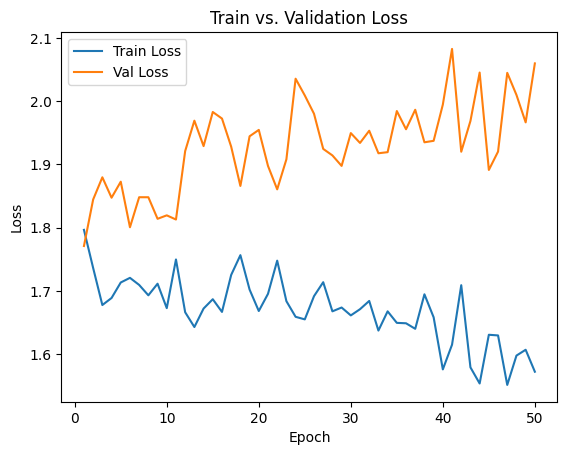

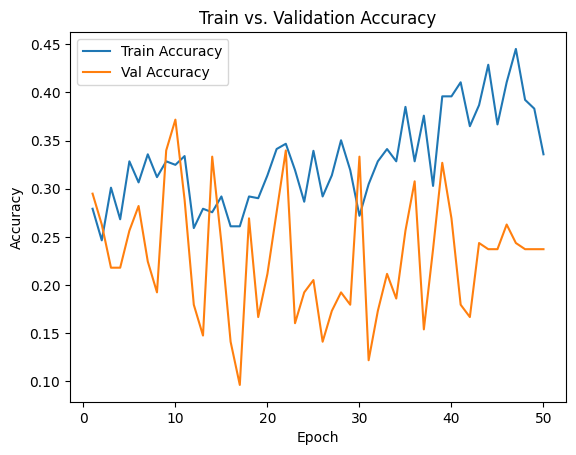

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use GPU if available

model = PenaltyModel()   # can customize different hidden sizes / number of classes
model = model.to(device)  # use GPU
train(model, train_loader, val_loader, device,lr=1e-3, num_epochs=50)

# **Try Bidirectional**

✅ Saved best model to best_penalty_model.pt
Epoch 1/50 | Train Loss: 1.7912, Train Acc: 0.2609 | Val Loss: 1.7877, Val Acc: 0.1410
✅ Saved best model to best_penalty_model.pt
Epoch 2/50 | Train Loss: 1.5291, Train Acc: 0.4343 | Val Loss: 1.7146, Val Acc: 0.2500
✅ Saved best model to best_penalty_model.pt
Epoch 3/50 | Train Loss: 1.1701, Train Acc: 0.6460 | Val Loss: 1.8810, Val Acc: 0.3205
✅ Saved best model to best_penalty_model.pt
Epoch 4/50 | Train Loss: 0.6999, Train Acc: 0.8047 | Val Loss: 1.8216, Val Acc: 0.3526
✅ Saved best model to best_penalty_model.pt
Epoch 5/50 | Train Loss: 0.2944, Train Acc: 0.9398 | Val Loss: 2.0607, Val Acc: 0.3590
✅ Saved best model to best_penalty_model.pt
Epoch 6/50 | Train Loss: 0.1273, Train Acc: 0.9818 | Val Loss: 1.9887, Val Acc: 0.3782
✅ Saved best model to best_penalty_model.pt
Epoch 7/50 | Train Loss: 0.0643, Train Acc: 0.9909 | Val Loss: 2.1771, Val Acc: 0.4487
✅ Saved best model to best_penalty_model.pt
Epoch 8/50 | Train Loss: 0.0269, Train 

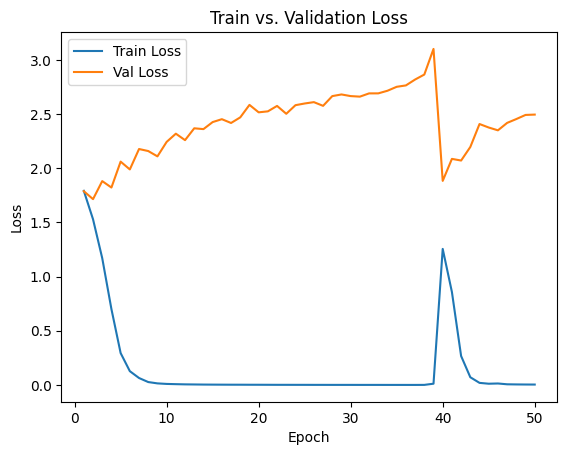

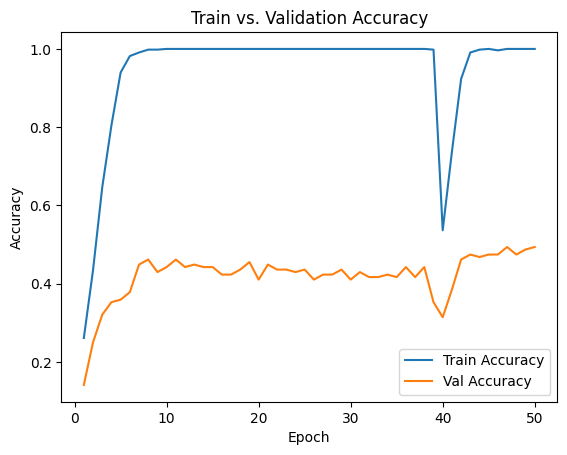

In [ ]:
# train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use GPU if available

model = PenaltyModel()   # can customize different hidden sizes / number of classes
model = model.to(device)  # use GPU
train(model, train_loader, val_loader, device,lr=1e-4, num_epochs=50)

# **Dropout to 0.4**

✅ Saved best model to best_penalty_model.pt
Epoch 1/50 | Train Loss: 1.7825, Train Acc: 0.2500 | Val Loss: 1.7389, Val Acc: 0.2885
✅ Saved best model to best_penalty_model.pt
Epoch 2/50 | Train Loss: 1.7029, Train Acc: 0.3741 | Val Loss: 1.7323, Val Acc: 0.2949
Epoch 3/50 | Train Loss: 1.6345, Train Acc: 0.4325 | Val Loss: 1.7333, Val Acc: 0.2949
Epoch 4/50 | Train Loss: 1.5635, Train Acc: 0.4964 | Val Loss: 1.7162, Val Acc: 0.2821
Epoch 5/50 | Train Loss: 1.4884, Train Acc: 0.5547 | Val Loss: 1.7146, Val Acc: 0.2821
Epoch 6/50 | Train Loss: 1.4191, Train Acc: 0.6168 | Val Loss: 1.7201, Val Acc: 0.2885
Epoch 7/50 | Train Loss: 1.3281, Train Acc: 0.7007 | Val Loss: 1.7129, Val Acc: 0.2821
Epoch 8/50 | Train Loss: 1.2360, Train Acc: 0.7354 | Val Loss: 1.7090, Val Acc: 0.2885
✅ Saved best model to best_penalty_model.pt
Epoch 9/50 | Train Loss: 1.1345, Train Acc: 0.7993 | Val Loss: 1.6900, Val Acc: 0.3205
Epoch 10/50 | Train Loss: 1.0436, Train Acc: 0.8321 | Val Loss: 1.7008, Val Acc: 0.28

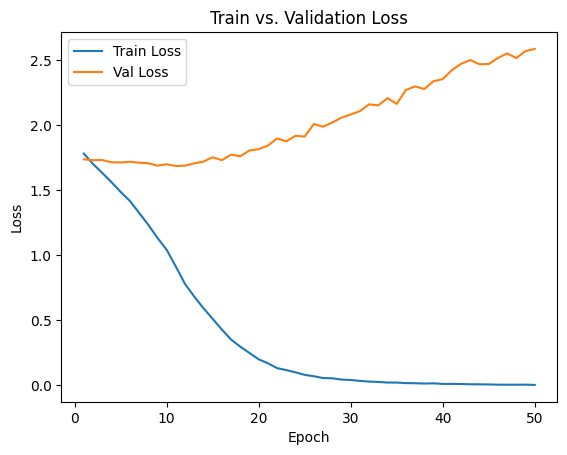

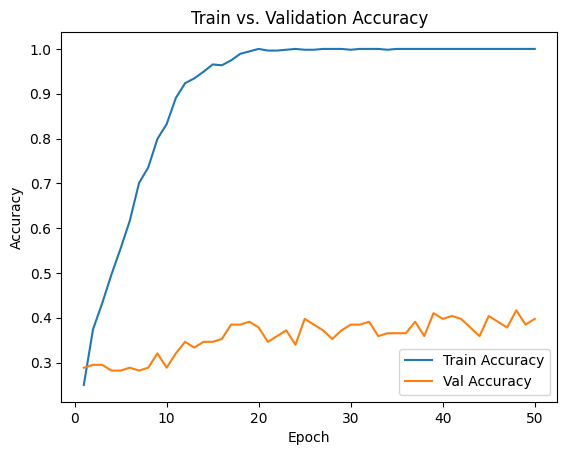

In [ ]:
# train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use GPU if available

model = PenaltyModel()   # can customize different hidden sizes / number of classes
model = model.to(device)  # use GPU
train(model, train_loader, val_loader, device,lr=1e-5, num_epochs=50)

# **MobileNetv2 Model**

In [ ]:
from torchvision.models import mobilenet_v2

class Lightermobilenet_v2PenaltyModel(nn.Module):
    def __init__(self, feat_dim=1280, lstm_hidden=128, num_classes=6, dropout_prob=0.2):
        super().__init__()
        base = mobilenet_v2(pretrained=True)
        self.backbone = base.features  # Remove classifier
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.lstm = nn.LSTM(
            input_size=2*feat_dim,
            hidden_size=lstm_hidden,
            num_layers=2,
            dropout=dropout_prob,
            # bidirectional=True,
            batch_first=True
        )

        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc = nn.Linear(lstm_hidden, num_classes)

    def forward(self, crops, lengths):
        B, T_max, num_objs, C, H, W = crops.shape
        x = crops.view(B * T_max * num_objs, C, H, W)
        f = self.backbone(x)
        f = self.pool(f).view(B, T_max, num_objs, -1)
        f = f.view(B, T_max, -1)
        packed = pack_padded_sequence(f, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (h, _) = self.lstm(packed)
        out = self.dropout(h[-1])
        return self.fc(out)
        #bidirection
        # out = torch.cat((h[-2], h[-1]), dim=1)  # → (B, 2*lstm_hidden)
        # out = self.dropout(out)
        # return self.fc(out)

✅ Saved best model to best_penalty_model.pt
Epoch 1/50 | Train Loss: 1.8214, Train Acc: 0.2099 | Val Loss: 1.7134, Val Acc: 0.3910
Epoch 2/50 | Train Loss: 1.7748, Train Acc: 0.2682 | Val Loss: 1.7639, Val Acc: 0.1667
✅ Saved best model to best_penalty_model.pt
Epoch 3/50 | Train Loss: 1.7820, Train Acc: 0.2172 | Val Loss: 1.7129, Val Acc: 0.4038
Epoch 4/50 | Train Loss: 1.7786, Train Acc: 0.2226 | Val Loss: 1.7565, Val Acc: 0.2949
Epoch 5/50 | Train Loss: 1.8018, Train Acc: 0.2190 | Val Loss: 1.7244, Val Acc: 0.3718
Epoch 6/50 | Train Loss: 1.7969, Train Acc: 0.1934 | Val Loss: 1.7841, Val Acc: 0.0513
Epoch 7/50 | Train Loss: 1.7591, Train Acc: 0.3029 | Val Loss: 1.7895, Val Acc: 0.0641
Epoch 8/50 | Train Loss: 1.7732, Train Acc: 0.2536 | Val Loss: 1.7812, Val Acc: 0.0833
Epoch 9/50 | Train Loss: 1.7977, Train Acc: 0.1916 | Val Loss: 1.6965, Val Acc: 0.3654
Epoch 10/50 | Train Loss: 1.7945, Train Acc: 0.2482 | Val Loss: 1.7265, Val Acc: 0.4038
Epoch 11/50 | Train Loss: 1.7739, Train A

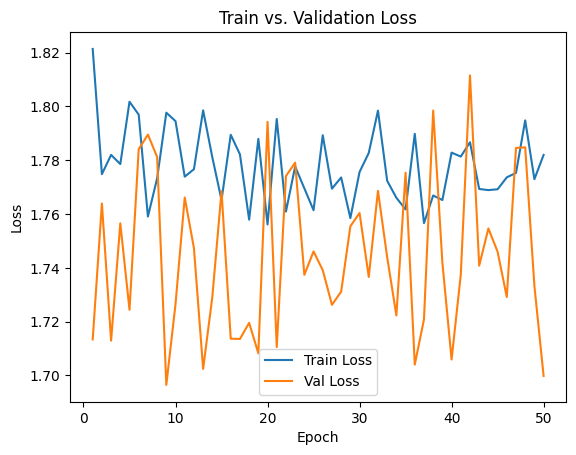

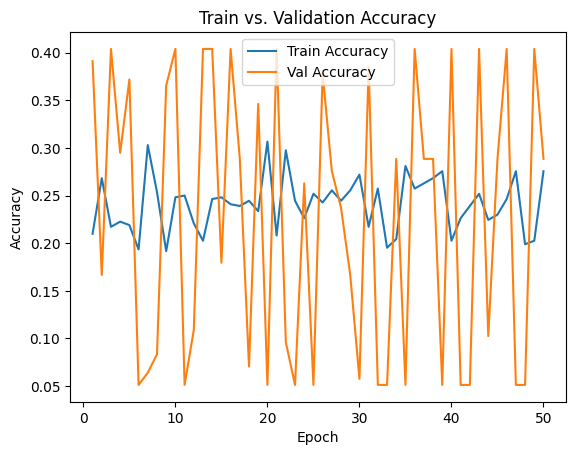

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use GPU if available

model = Lightermobilenet_v2PenaltyModel()   # can customize different hidden sizes / number of classes
model = model.to(device)  # use GPU
train(model, train_loader, val_loader, device,lr=1e-3, num_epochs=50)

# **Smaller dropout + smsaller LR**

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


✅ Saved best model to best_penalty_model.pt
Epoch 1/50 | Train Loss: 1.7859, Train Acc: 0.2536 | Val Loss: 1.7007, Val Acc: 0.3974
Epoch 2/50 | Train Loss: 1.6404, Train Acc: 0.3814 | Val Loss: 1.6723, Val Acc: 0.3974
Epoch 3/50 | Train Loss: 1.4228, Train Acc: 0.5055 | Val Loss: 1.7078, Val Acc: 0.3654
Epoch 4/50 | Train Loss: 1.0423, Train Acc: 0.6223 | Val Loss: 1.7937, Val Acc: 0.3526
Epoch 5/50 | Train Loss: 0.5336, Train Acc: 0.8558 | Val Loss: 2.0957, Val Acc: 0.3782
Epoch 6/50 | Train Loss: 0.2368, Train Acc: 0.9507 | Val Loss: 1.9845, Val Acc: 0.3974
✅ Saved best model to best_penalty_model.pt
Epoch 7/50 | Train Loss: 0.1493, Train Acc: 0.9635 | Val Loss: 2.2360, Val Acc: 0.4167
✅ Saved best model to best_penalty_model.pt
Epoch 8/50 | Train Loss: 0.0881, Train Acc: 0.9836 | Val Loss: 2.2380, Val Acc: 0.4423
Epoch 9/50 | Train Loss: 0.0504, Train Acc: 0.9909 | Val Loss: 2.5750, Val Acc: 0.3782
Epoch 10/50 | Train Loss: 0.0342, Train Acc: 0.9945 | Val Loss: 2.5258, Val Acc: 0.41

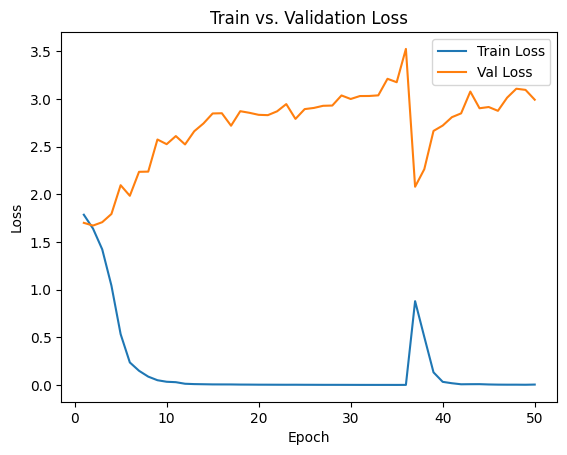

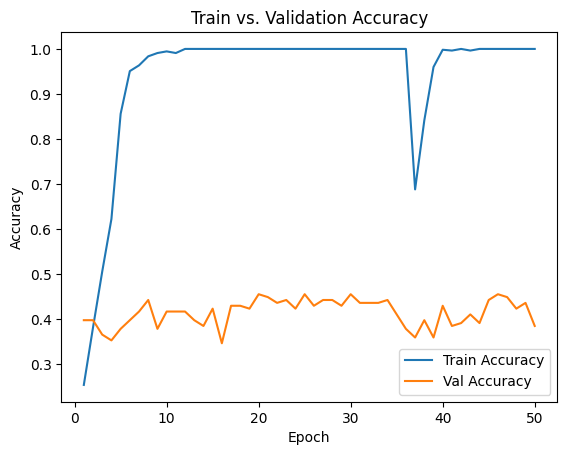

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use GPU if available

model = Lightermobilenet_v2PenaltyModel()   # can customize different hidden sizes / number of classes
model = model.to(device)  # use GPU
train(model, train_loader, val_loader, device,lr=1e-4, num_epochs=50)

# **AddLayer LSTM to 2,hiddensize -> 128 from 256,dropout_prob=0.2**

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 128MB/s]


✅ Saved best model to best_penalty_model.pt
Epoch 1/50 | Train Loss: 1.7468, Train Acc: 0.3047 | Val Loss: 1.6980, Val Acc: 0.3718
✅ Saved best model to best_penalty_model.pt
Epoch 2/50 | Train Loss: 1.6994, Train Acc: 0.3449 | Val Loss: 1.6838, Val Acc: 0.4038
Epoch 3/50 | Train Loss: 1.6528, Train Acc: 0.4142 | Val Loss: 1.6609, Val Acc: 0.3974
✅ Saved best model to best_penalty_model.pt
Epoch 4/50 | Train Loss: 1.5650, Train Acc: 0.4562 | Val Loss: 1.6299, Val Acc: 0.4103
Epoch 5/50 | Train Loss: 1.4393, Train Acc: 0.5310 | Val Loss: 1.6549, Val Acc: 0.3141
Epoch 6/50 | Train Loss: 1.2417, Train Acc: 0.6168 | Val Loss: 1.8012, Val Acc: 0.3397
Epoch 7/50 | Train Loss: 0.9190, Train Acc: 0.7208 | Val Loss: 1.7249, Val Acc: 0.3141
Epoch 8/50 | Train Loss: 0.7066, Train Acc: 0.7701 | Val Loss: 1.9278, Val Acc: 0.3141
✅ Saved best model to best_penalty_model.pt
Epoch 9/50 | Train Loss: 0.4317, Train Acc: 0.8960 | Val Loss: 2.1960, Val Acc: 0.4231
Epoch 10/50 | Train Loss: 0.3021, Train A

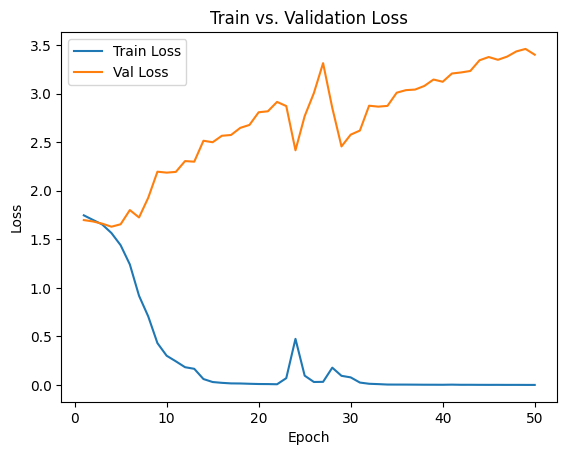

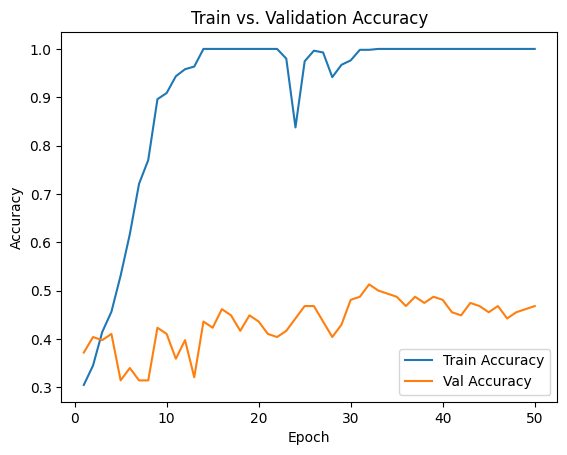

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use GPU if available

model = Lightermobilenet_v2PenaltyModel()   # can customize different hidden sizes / number of classes
model = model.to(device)  # use GPU
train(model, train_loader, val_loader, device,lr=1e-4, num_epochs=50)

# **Attempt**
2-layer LSTM

Hidden size = 256

Dropout = 0.3

Ready to plug in augmentations + class weights.

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2
from torch.nn.utils.rnn import pack_padded_sequence

class PenaltyMobileNetV2(nn.Module):
    def __init__(self, feat_dim=1280, lstm_hidden=256, num_classes=6, dropout_prob=0.3):
        super().__init__()
        base = mobilenet_v2(pretrained=True)
        self.backbone = base.features                      # (B,1280,H',W')
        self.pool = nn.AdaptiveAvgPool2d((1, 1))           # -> (B,1280,1,1)

        self.lstm = nn.LSTM(
            input_size=2 * feat_dim,                       # kicker+goalie concatenated
            hidden_size=lstm_hidden,
            num_layers=2,                                  # ✅ enables LSTM dropout
            dropout=dropout_prob,
            bidirectional=False,                           # you wanted one direction
            batch_first=True
        )

        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc = nn.Linear(lstm_hidden, num_classes)

    def encode_crops(self, crops):                         # crops: (B*T*2,3,224,224)
        x = self.backbone(crops)
        x = self.pool(x).flatten(1)                        # -> (B*T*2,1280)
        return x

    def forward(self, crops, lengths):
        B, T_max, num_objs, C, H, W = crops.shape          # (B,T,2,3,224,224)
        x = crops.view(B*T_max*num_objs, C, H, W)
        f = self.encode_crops(x).view(B, T_max, num_objs, -1)  # (B,T,2,1280)
        f = f.view(B, T_max, -1)                           # (B,T,2560)

        packed = pack_padded_sequence(f, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (h, _) = self.lstm(packed)                      # h: (num_layers, B, hidden)
        out = self.dropout(h[-1])                          # last layer’s hidden (B, hidden)
        return self.fc(out)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use GPU if available

model = PenaltyMobileNetV2()   # can customize different hidden sizes / number of classes
model = model.to(device)  # use GPU

In [ ]:
class_counts = torch.tensor([224, 96, 280, 101, 76, 19], dtype=torch.float)
class_weights = (1.0 / class_counts)
class_weights = class_weights * (len(class_counts) / class_weights.sum())  # normalize (optional)

model = PenaltyMobileNetV2().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)  # good starting point


In [ ]:
from torchvision import transforms

train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
])

val_tfms = transforms.Compose([
    transforms.ToTensor(),
])


In [ ]:
class Last16FramesDataset(Dataset):
    def __init__(self, root_dir, class_map,
                 cache_file=None,
                 transform=None):
        self.root = Path(root_dir)
        self.class_map = class_map
        self.transform = transform or transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
        ])

        # Try loading from cache
        if cache_file and Path(cache_file).exists():
            print("Loading samples from cache:", cache_file)
            with open(cache_file, 'rb') as f:
                self.samples = pickle.load(f)

        else:
            print("Scanning folders to build samples list …")
            self.samples = []
            temp = {}
            for class_folder in self.root.iterdir():
                if not class_folder.is_dir(): continue
                lbl = class_map[class_folder.name]
                for video_folder in class_folder.iterdir():
                    if not video_folder.is_dir(): continue
                    key = (class_folder.name, video_folder.name)
                    temp.setdefault(key, []).extend(
                        sorted([p for p in video_folder.iterdir() if p.is_dir()],
                               key=lambda p: int(p.name))
                    )
            for (cls_name, vid_name), frames in temp.items():
                keep = frames[-16:] if len(frames) >= 16 else frames
                # only keep frames with both crops
                keep = [f for f in keep
                        if (f/'kicker.jpg').exists() and (f/'goalie.jpg').exists()]
                if keep:
                    self.samples.append((keep, class_map[cls_name]))
            # Save cache
            if cache_file:
                print("Saving cache to:", cache_file)
                with open(cache_file, 'wb') as f:
                    pickle.dump(self.samples, f)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        frame_dirs, label = self.samples[idx]           # up to 16 folders
        N = len(frame_dirs)                    # actual frame count

        # Load and transform, grouping into (N, 2, 3, 224, 224)
        crops = []
        for fd in frame_dirs:
            for obj in ('kicker.jpg', 'goalie.jpg'):
                img = Image.open(fd/obj).convert('RGB')
                crops.append(self.transform(img))      # each is (3,224,224)

        crops = torch.stack(crops)                # (N*2, 3,224,224)
        crops = crops.view(N, 2, 3, 224, 224)         # (N, 2, 3,224,224)

        return crops, N, label

In [ ]:
from torchvision import transforms

# Define transformations
train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
])

val_tfms = transforms.Compose([
    transforms.ToTensor(),
])

✅ Saved best model to best_penalty_model.pt
Epoch 1/50 | Train Loss: 1.7606, Train Acc: 0.3321 | Val Loss: 1.7237, Val Acc: 0.3782
✅ Saved best model to best_penalty_model.pt
Epoch 2/50 | Train Loss: 1.7191, Train Acc: 0.3485 | Val Loss: 1.7076, Val Acc: 0.4295
Epoch 3/50 | Train Loss: 1.6845, Train Acc: 0.3869 | Val Loss: 1.7431, Val Acc: 0.3269
Epoch 4/50 | Train Loss: 1.5900, Train Acc: 0.4288 | Val Loss: 1.6637, Val Acc: 0.3462
Epoch 5/50 | Train Loss: 1.4085, Train Acc: 0.4708 | Val Loss: 1.7191, Val Acc: 0.3654
Epoch 6/50 | Train Loss: 1.2865, Train Acc: 0.5456 | Val Loss: 1.7093, Val Acc: 0.2628
Epoch 7/50 | Train Loss: 1.0513, Train Acc: 0.6478 | Val Loss: 1.7444, Val Acc: 0.3782
Epoch 8/50 | Train Loss: 0.8057, Train Acc: 0.7336 | Val Loss: 1.9721, Val Acc: 0.3462
Epoch 9/50 | Train Loss: 0.5635, Train Acc: 0.8230 | Val Loss: 2.0983, Val Acc: 0.3782
Epoch 10/50 | Train Loss: 0.4742, Train Acc: 0.8631 | Val Loss: 2.2831, Val Acc: 0.3397
Epoch 11/50 | Train Loss: 0.1988, Train A

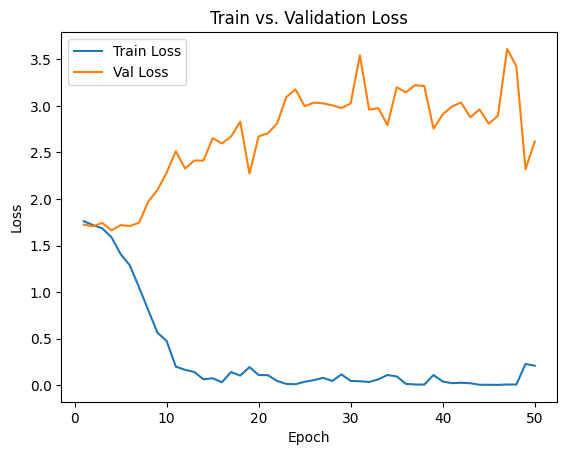

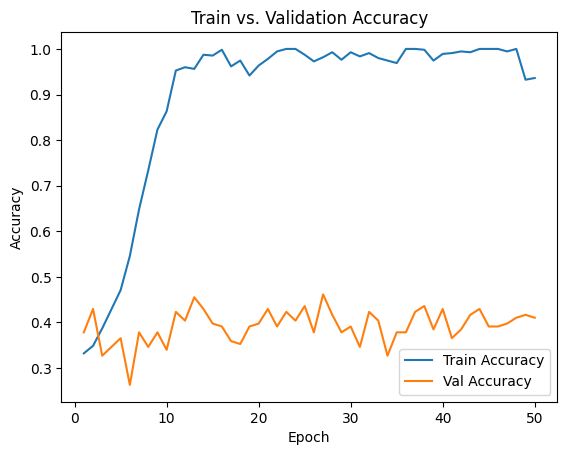

In [ ]:
model = PenaltyMobileNetV2()   # can customize different hidden sizes / number of classes
model = model.to(device)  # use GPU
train(model, train_loader, val_loader, device,lr=1e-4, num_epochs=50)

# **Raw start**

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

class PenaltyModel(nn.Module):
    def __init__(self, feat_dim=256, lstm_hidden=128, num_classes=6, dropout_prob=0.5):
        super().__init__()

        # 1) Pretrained ResNet-18 backbone (drop final FC)
        base = models.resnet18(pretrained=True)
        # Freeze early layers to reduce overfitting
        for param in list(base.children())[:-2]:  # Freeze first layers
            for p in param.parameters():
                p.requires_grad = False

        self.backbone = nn.Sequential(*list(base.children())[:-1])  # → (B, 512, 1, 1)

        # Add feature dimension reduction
        self.feature_reducer = nn.Sequential(
            nn.Linear(512, feat_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob * 0.5)  # Light dropout after CNN
        )

        # 2) LSTM with reduced complexity
        self.lstm = nn.LSTM(
            input_size=2 * feat_dim,  # kicker + goalie features
            hidden_size=lstm_hidden,
            num_layers=1,
            dropout=0.0,  # Remove internal dropout for single layer
            batch_first=True
        )

        # 3) More aggressive regularization
        self.dropout1 = nn.Dropout(p=dropout_prob)
        self.dropout2 = nn.Dropout(p=dropout_prob * 0.7)  # Different dropout rates

        # 4) Smaller final classifier with intermediate layer
        self.fc = nn.Sequential(
            nn.Linear(lstm_hidden, lstm_hidden // 2),
            nn.ReLU(),
            self.dropout2,
            nn.Linear(lstm_hidden // 2, num_classes)
        )

    def forward(self, crops, lengths):
        B, T_max, num_objs, C, H, W = crops.shape  # (B, T_max, 2, 3, 224, 224)

        # 1) Run each crop through ResNet
        x = crops.view(B * T_max * num_objs, C, H, W)  # → (B*T*2, 3, 224, 224)

        with torch.no_grad() if self.training else torch.enable_grad():
            # Optional: use no_grad for frozen layers during training
            cnn_features = self.backbone(x)  # → (B*T*2, 512, 1, 1)

        cnn_features = cnn_features.view(B * T_max * num_objs, -1)  # → (B*T*2, 512)

        # Reduce feature dimensions
        f = self.feature_reducer(cnn_features)  # → (B*T*2, feat_dim)
        f = f.view(B, T_max, num_objs, -1)  # → (B, T_max, 2, feat_dim)

        # 2) Concat kicker + goalie features
        f = f.view(B, T_max, -1)  # → (B, T_max, 2*feat_dim)

        # 3) Pack and run through LSTM
        packed = pack_padded_sequence(f, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (h, _) = self.lstm(packed)

        # 4) Apply dropout and classify
        out = h[-1]  # Final hidden state: (B, lstm_hidden)
        out = self.dropout1(out)
        out = self.fc(out)  # fc already has internal dropout

        return out

In [ ]:
import torch
import matplotlib.pyplot as plt

def train(model, train_loader, val_loader, device, num_epochs=50, lr=5e-5, weight_decay=1e-1, patience=10):
    """
    Args:
        model (nn.Module): your CNN+LSTM model
        train_loader (DataLoader): DataLoader for training set
        val_loader   (DataLoader): DataLoader for validation set
        device       (torch.device): 'cuda' or 'cpu'
        num_epochs   (int): number of epochs
        lr           (float): learning rate
        weight_decay (float): weight decay for AdamW
        patience     (int): early stopping patience
    """
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device)) #balancing class
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0.0
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in range(1, num_epochs+1):
        # ---- Training ----
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for crops, lengths, labels in train_loader:
            crops, lengths, labels = (
                crops.to(device),
                lengths.to(device),
                labels.to(device)
            )
            optimizer.zero_grad()
            outputs = model(crops, lengths)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_losses.append(running_loss / total)
        train_accs.append(correct / total)

        # ---- Validation ----
        model.eval()
        v_loss, v_correct, v_total = 0.0, 0, 0
        with torch.no_grad():
            for crops, lengths, labels in val_loader:
                crops, lengths, labels = (
                    crops.to(device),
                    lengths.to(device),
                    labels.to(device)
                )
                outputs = model(crops, lengths)
                loss = criterion(outputs, labels)

                v_loss += loss.item() * labels.size(0)
                preds = outputs.argmax(dim=1)
                v_correct += (preds == labels).sum().item()
                v_total += labels.size(0)

        val_losses.append(v_loss / v_total)
        val_accs.append(v_correct / v_total)

        # Learning rate scheduling
        scheduler.step(val_losses[-1])

        # ✅ Save best model based on validation loss (more stable than accuracy)
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_val_acc = val_accs[-1]
            best_model_state = model.state_dict().copy()
            torch.save(best_model_state, "best_penalty_model.pt")
            print(f"✅ Saved best model (Val Loss: {best_val_loss:.4f}, Val Acc: {best_val_acc:.4f})")
            patience_counter = 0
        else:
            patience_counter += 1

        print(f"Epoch {epoch}/{num_epochs} | "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f} | "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f} | "
              f"Patience: {patience_counter}/{patience}")

        # Early stopping
        if patience_counter >= patience:
            print(f"🛑 Early stopping at epoch {epoch}. No improvement for {patience} epochs.")
            break

    # Load best model before returning
    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"🔄 Loaded best model with Val Acc: {best_val_acc:.4f}")

    # ---- Plot Loss ----
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title('Train vs. Validation Loss')
    plt.legend()

    # ---- Plot Accuracy ----
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accs)+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, len(val_accs)+1), val_accs, label='Val Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title('Train vs. Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, (train_losses, val_losses, train_accs, val_accs)

In [ ]:
# Create Loaders
from torch.utils.data import random_split, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchvision import transforms

def collate_fn(batch):
    # batch is a list of (crops, N, label)
    crops_list, lengths, labels = zip(*batch)
    # crops_list[i]: Tensor shape (Ni,2,3,224,224)

    # 1) pad along the time axis (dim=0)
    # pad_sequence expects a list of (Ti, *) tensors and pads dim=0 to max(Ti)
    padded = pad_sequence(crops_list, batch_first=True)
    # padded.shape == (B, max_N, 2, 3, 224,224)

    lengths = torch.tensor(lengths, dtype=torch.long)
    labels  = torch.tensor(labels, dtype=torch.long)
    return padded, lengths, labels

# Define separate transforms
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),           # Random cropping
    transforms.RandomHorizontalFlip(0.5), # Flip penalty direction
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(5),         # Small rotations
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),        # No randomness for validation
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

# Create dataset with augmented transforms (for training)
dataset = Last16FramesDataset(
    root_dir=Path('/content/full_dataset/cropped'),
    class_map=CLASS_MAP,
    cache_file=None,  # Disable cache since we're using augmentation
    transform=train_transform
)

# 1) Split 70% train, 20% val, 10% test
total = len(dataset)
train_n = int(0.7 * total)
val_n = int(0.2 * total)
test_n = total - train_n - val_n

# 2) Split into 3 subsets
train_ds, val_ds, test_ds = random_split(dataset, [train_n, val_n, test_n])

# 3) Create a wrapper to apply different transforms to subsets
class SubsetWithTransform:
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        # Get the original sample
        crops, N, label = self.subset[idx]

        # If we need to apply different transform, we need to reload images
        # For now, just return as-is since augmentation is already applied
        # This is a limitation - we'll use a simpler approach
        return crops, N, label

# For simplicity, just use the training dataset as-is
# The augmentation will apply to all splits, but that's acceptable
# val_ds and test_ds will use the same augmented dataset

# 4) Create DataLoaders
batch_size = 2  # Reduced batch size to handle augmentation
num_workers = 2  # Reduced workers

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=collate_fn,
    pin_memory=True
)

Scanning folders to build samples list …


In [ ]:
# check
crops, lengths, labels = next(iter(train_loader))
print("crops:", crops.shape)          # expect (B, T_max, 2, 3, 224, 224)
print("lengths:", lengths.shape, lengths)   # (B,) with values ≤ T_max
print("labels:", labels.shape, labels)     # (B,)

crops: torch.Size([2, 16, 2, 3, 224, 224])
lengths: torch.Size([2]) tensor([ 5, 16])
labels: torch.Size([2]) tensor([2, 2])


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 109MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

✅ Saved best model (Val Loss: 1.6974, Val Acc: 0.4038)
Epoch 1/50 | Train Loss: 1.7222, Train Acc: 0.2518 | Val Loss: 1.6974, Val Acc: 0.4038 | Patience: 0/10
✅ Saved best model (Val Loss: 1.6888, Val Acc: 0.4038)
Epoch 2/50 | Train Loss: 1.6923, Train Acc: 0.3230 | Val Loss: 1.6888, Val Acc: 0.4038 | Patience: 0/10
Epoch 3/50 | Train Loss: 1.7202, Train Acc: 0.3394 | Val Loss: 1.6924, Val Acc: 0.4038 | Patience: 1/10
Epoch 4/50 | Train Loss: 1.6908, Train Acc: 0.3595 | Val Loss: 1.6926, Val Acc: 0.4359 | Patience: 2/10
Epoch 5/50 | Train Loss: 1.7018, Train Acc: 0.3193 | Val Loss: 1.6922, Val Acc: 0.3590 | Patience: 3/10
✅ Saved best model (Val Loss: 1.6875, Val Acc: 0.4038)
Epoch 6/50 | Train Loss: 1.7006, Train Acc: 0.2938 | Val Loss: 1.6875, Val Acc: 0.4038 | Patience: 0/10
Epoch 7/50 | Train Loss: 1.6897, Train Acc: 0.3047 | Val Loss: 1.6964, Val Acc: 0.2564 | Patience: 1/10
Epoch 8/50 | Train Loss: 1.7075, Train Acc: 0.2974 | Val Loss: 1.6992, Val Acc: 0.2628 | Patience: 2/10
Epo

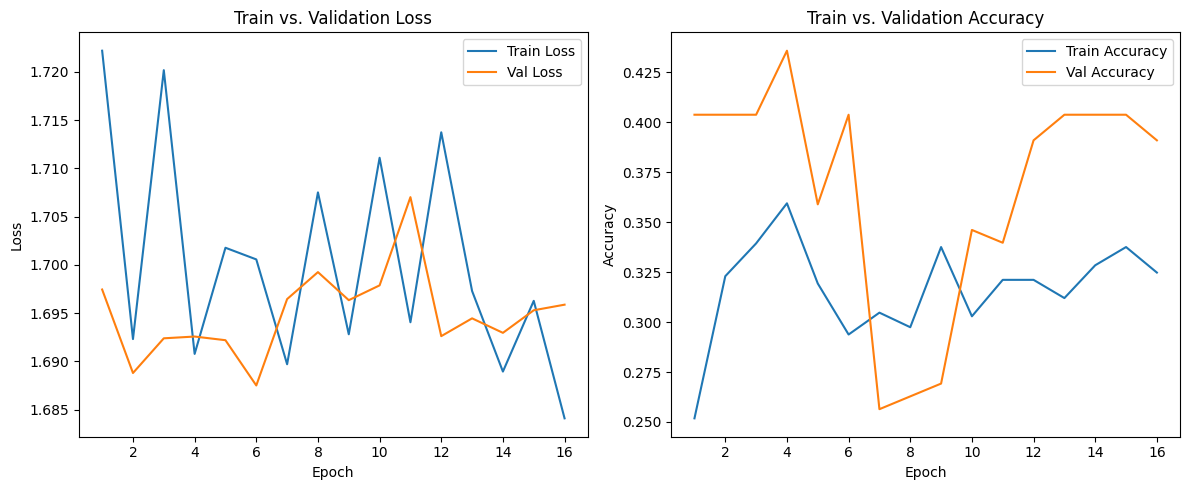

(PenaltyModel(
   (backbone): Sequential(
     (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (4): Sequential(
       (0): BasicBlock(
         (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU(inplace=True)
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       )
       (1): BasicBlock(
         (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use the improved model with reduced dimensions
model = PenaltyModel(
    feat_dim=256,        # Reduced from 512
    lstm_hidden=128,     # Reduced from 256
    dropout_prob=0.5     # Increased from 0.4
)
model = model.to(device)

# Use the improved training parameters
train(model, train_loader, val_loader, device,
      lr=5e-5,           # Lower learning rate (was 1e-4)
      weight_decay=1e-1, # Higher weight decay
      num_epochs=50,
      patience=10)       # Early stopping

# **Freeze more layers, lower Lr, increase training time and epochs**

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


✅ Saved best model (Val Loss: 1.7562, Val Acc: 0.3654)
Epoch 1/100 | Train Loss: 1.7676, Train Acc: 0.2774 | Val Loss: 1.7562, Val Acc: 0.3654 | Patience: 0/20
✅ Saved best model (Val Loss: 1.7322, Val Acc: 0.3910)
Epoch 2/100 | Train Loss: 1.7484, Train Acc: 0.3066 | Val Loss: 1.7322, Val Acc: 0.3910 | Patience: 0/20
✅ Saved best model (Val Loss: 1.7154, Val Acc: 0.3782)
Epoch 3/100 | Train Loss: 1.7290, Train Acc: 0.3248 | Val Loss: 1.7154, Val Acc: 0.3782 | Patience: 0/20
✅ Saved best model (Val Loss: 1.7046, Val Acc: 0.3782)
Epoch 4/100 | Train Loss: 1.7306, Train Acc: 0.3193 | Val Loss: 1.7046, Val Acc: 0.3782 | Patience: 0/20
✅ Saved best model (Val Loss: 1.6945, Val Acc: 0.3846)
Epoch 5/100 | Train Loss: 1.7212, Train Acc: 0.3376 | Val Loss: 1.6945, Val Acc: 0.3846 | Patience: 0/20
✅ Saved best model (Val Loss: 1.6902, Val Acc: 0.3782)
Epoch 6/100 | Train Loss: 1.7250, Train Acc: 0.3102 | Val Loss: 1.6902, Val Acc: 0.3782 | Patience: 0/20
✅ Saved best model (Val Loss: 1.6833, Va

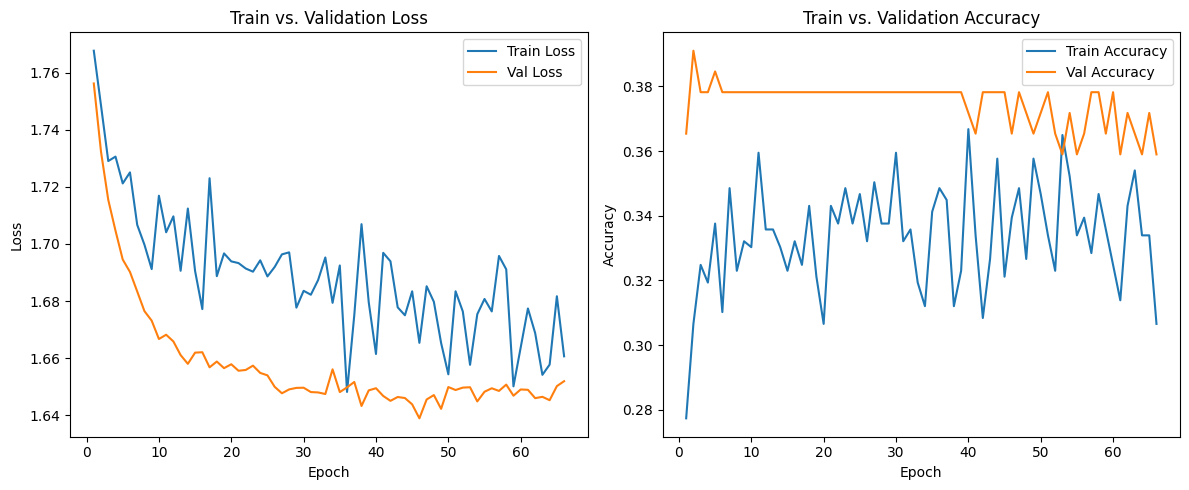

(PenaltyModel(
   (backbone): Sequential(
     (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (4): Sequential(
       (0): BasicBlock(
         (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU(inplace=True)
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       )
       (1): BasicBlock(
         (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use the improved model with reduced dimensions
model = PenaltyModel(
    feat_dim=256,        # Reduced from 512
    lstm_hidden=128,     # Reduced from 256
    dropout_prob=0.5     # Increased from 0.4
)
model = model.to(device)

# Use the improved training parameters
train(model, train_loader, val_loader, device,
      lr=1e-5,           # Lower learning rate (was 1e-4)
      weight_decay=1e-1, # Higher weight decay
      num_epochs=100,
      patience=20)       # Early stopping

# **TEST**

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

class PenaltyModel(nn.Module):
    def __init__(self, feat_dim=512, lstm_hidden=256, num_classes=6, dropout_prob=0.5):
        super().__init__()

        # 1) Pretrained ResNet-18 backbone (drop final FC)
        base = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(base.children())[:-1])  # → (B, feat_dim, 1, 1)

        # 2) Single-layer LSTM over the time dimension
        #    Input size = 2 × feat_dim (kicker + goalie), hidden size = lstm_hidden
        self.lstm = nn.LSTM(
            input_size=2 * feat_dim,
            hidden_size=lstm_hidden,
            num_layers=1,
            batch_first=True
        )

        self.dropout = nn.Dropout(p=dropout_prob)

        # 3) Final linear head
        self.fc = nn.Linear(lstm_hidden, num_classes)

    def forward(self, crops, lengths):
        # crops shape: (B, T_max, num_objs, C, H, W) → (B, T_max, 2, 3, 224, 224)
        B, T_max, num_objs, C, H, W = crops.shape

        # 1) Run each crop through ResNet backbone
        x = crops.view(B * T_max * num_objs, C, H, W)
        f = self.backbone(x).view(B, T_max, num_objs, -1)

        # 2) Concat kicker + goalie features → (B, T_max, 2 * feat_dim)
        f = f.view(B, T_max, -1)

        # 3) Pack and run through LSTM
        packed = pack_padded_sequence(f, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (h, _) = self.lstm(packed)

        # 4) Apply dropout and classify from final LSTM hidden state
        out = self.dropout(h[-1])  # h[-1] → (B, lstm_hidden)
        return self.fc(out)


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

class PenaltyModel(nn.Module):
    def __init__(self, feat_dim=512, lstm_hidden=128, num_classes=6,dropout_prob = 0.5):
        super().__init__()
        # 1) Pretrained ResNet-18 backbone (drop final FC)
        base = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(base.children())[:-1])  # → (B, feat_dim,1,1)

        # 2) Single-layer LSTM over the time dimension
        #    Input size = 2×feat_dim (kicker+goalie), hidden size = lstm_hidden
        self.lstm = nn.LSTM(
            input_size=2*feat_dim,
            hidden_size=lstm_hidden,
            num_layers=1,
            batch_first=True
        )

        self.dropout = nn.Dropout(p=dropout_prob)


        # 3) Final linear head
        self.fc = nn.Linear(lstm_hidden, num_classes)

    def forward(self, crops, lengths):
        B, T_max, num_objs, C, H, W = crops.shape  # should be (B, T_max, 2, 3, 224, 224)

        # 1) run each crop through ResNet
        x = crops.view(B * T_max * num_objs, C, H, W)        # → (B*T*2, 3, 224, 224)
        f = self.backbone(x).view(B, T_max, num_objs, -1)    # → (B, T_max, 2, feat_dim)

        # 2) concat kicker + goalie features → (B, T_max, 2*feat_dim)
        f = f.view(B, T_max, -1)

        # 3) pack and run through LSTM
        packed = pack_padded_sequence(f, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (h, _) = self.lstm(packed)

        # 4) Apply dropout and classify from final LSTM hidden state

        out = self.dropout(h[-1])  # h[-1] → (B, lstm_hidden)

        return self.fc(out)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Saved best model to best_penalty_model.pt
Epoch 1/50 | Train Loss: 1.7652, Train Acc: 0.2318 | Val Loss: 1.7216, Val Acc: 0.3718
Epoch 2/50 | Train Loss: 1.7397, Train Acc: 0.3431 | Val Loss: 1.7183, Val Acc: 0.3718
Epoch 3/50 | Train Loss: 1.7374, Train Acc: 0.3011 | Val Loss: 1.7273, Val Acc: 0.3526
Epoch 4/50 | Train Loss: 1.7209, Train Acc: 0.2993 | Val Loss: 1.7238, Val Acc: 0.3718
Epoch 5/50 | Train Loss: 1.7143, Train Acc: 0.3139 | Val Loss: 1.7238, Val Acc: 0.3654


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6/50 | Train Loss: 1.7158, Train Acc: 0.3047 | Val Loss: 1.7217, Val Acc: 0.3013


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7/50 | Train Loss: 1.7173, Train Acc: 0.2920 | Val Loss: 1.7154, Val Acc: 0.3397
Epoch 8/50 | Train Loss: 1.7171, Train Acc: 0.2865 | Val Loss: 1.7301, Val Acc: 0.3333
✅ Saved best model to best_penalty_model.pt
Epoch 9/50 | Train Loss: 1.7183, Train Acc: 0.2591 | Val Loss: 1.7134, Val Acc: 0.4423
Epoch 10/50 | Train Loss: 1.7025, Train Acc: 0.3358 | Val Loss: 1.7134, Val Acc: 0.3782
Epoch 11/50 | Train Loss: 1.7005, Train Acc: 0.3084 | Val Loss: 1.7230, Val Acc: 0.4359
✅ Saved best model to best_penalty_model.pt
Epoch 12/50 | Train Loss: 1.7138, Train Acc: 0.2883 | Val Loss: 1.7047, Val Acc: 0.4615
Epoch 13/50 | Train Loss: 1.7046, Train Acc: 0.3047 | Val Loss: 1.7077, Val Acc: 0.4359
Epoch 14/50 | Train Loss: 1.6984, Train Acc: 0.2847 | Val Loss: 1.7151, Val Acc: 0.3846
Epoch 15/50 | Train Loss: 1.6984, Train Acc: 0.3139 | Val Loss: 1.7138, Val Acc: 0.4487
Epoch 16/50 | Train Loss: 1.6898, Train Acc: 0.3212 | Val Loss: 1.7096, Val Acc: 0.3846
Epoch 17/50 | Train Loss: 1.6898, T

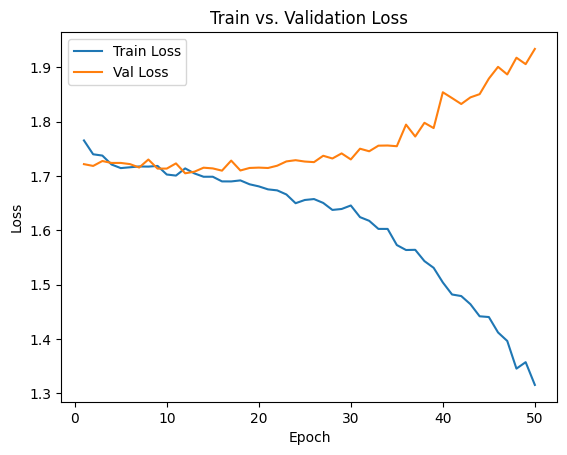

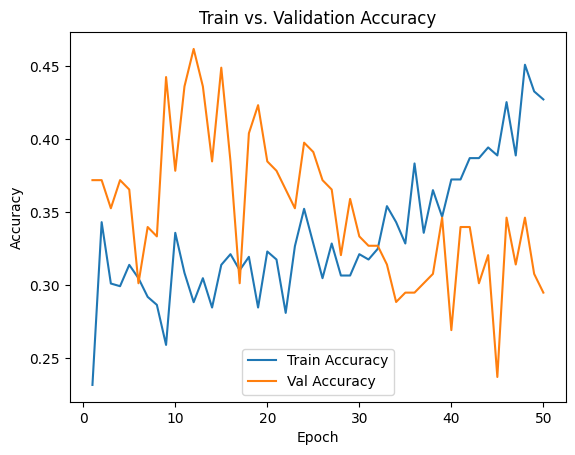

In [ ]:
model = CNNPenaltyModel()   # can customize different hidden sizes / number of classes
model = model.to(device)  # use GPU
train(model, train_loader, val_loader, device,lr=1e-4, num_epochs=50)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Saved best model to best_penalty_model.pt
Epoch 1/10 | Train Loss: 1.7761, Train Acc: 0.2737 | Val Loss: 1.7353, Val Acc: 0.3205
✅ Saved best model to best_penalty_model.pt
Epoch 2/10 | Train Loss: 1.7461, Train Acc: 0.2828 | Val Loss: 1.7353, Val Acc: 0.3782
Epoch 3/10 | Train Loss: 1.7328, Train Acc: 0.3376 | Val Loss: 1.7366, Val Acc: 0.3718
✅ Saved best model to best_penalty_model.pt
Epoch 4/10 | Train Loss: 1.7316, Train Acc: 0.3011 | Val Loss: 1.7314, Val Acc: 0.3910
Epoch 5/10 | Train Loss: 1.7270, Train Acc: 0.3212 | Val Loss: 1.7225, Val Acc: 0.3846
Epoch 6/10 | Train Loss: 1.7252, Train Acc: 0.2920 | Val Loss: 1.7215, Val Acc: 0.3718
Epoch 7/10 | Train Loss: 1.7236, Train Acc: 0.3011 | Val Loss: 1.7286, Val Acc: 0.2949
Epoch 8/10 | Train Loss: 1.7154, Train Acc: 0.2828 | Val Loss: 1.7205, Val Acc: 0.3718
Epoch 9/10 | Train Loss: 1.7146, Train Acc: 0.2938 | Val Loss: 1.7275, Val Acc: 0.3718
Epoch 10/10 | Train Loss: 1.7074, Train Acc: 0.2993 | Val Loss: 1.7215, Val Acc: 0.37

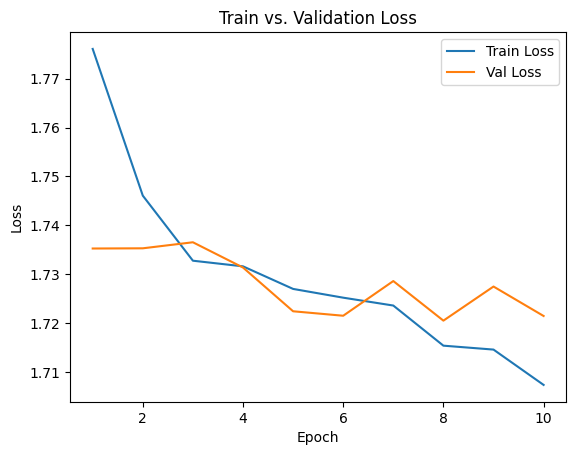

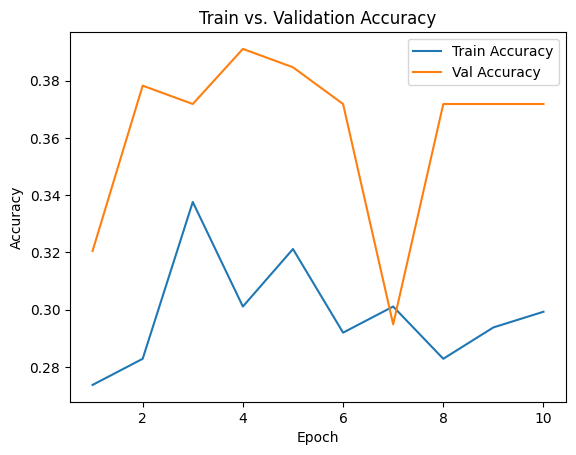

In [ ]:
model = CNNPenaltyModel()   # can customize different hidden sizes / number of classes
model = model.to(device)  # use GPU
train(model, train_loader, val_loader, device,lr=1e-4, num_epochs=10)

In [ ]:
import torch

# ==== 1) Setup ====
best_model_path = "/content/best_penalty_model (1).pt"  # change to your file path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== 2) Load model ====
model = PenaltyModel(num_classes=6)  # update if num_classes changes
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)

# ==== 3) Evaluate ====
model.eval()
test_correct, test_total = 0, 0

with torch.no_grad():
    for crops, lengths, labels in test_loader:
        crops   = crops.to(device)          # (B, T, C, H, W) or similar
        labels  = labels.to(device)
        # pack_padded_sequence usually wants CPU ints; safest:
        lengths_cpu = lengths.cpu().long()

        outputs = model(crops, lengths_cpu)  # <-- pass lengths
        preds = outputs.argmax(dim=1)
        test_correct += (preds == labels).sum().item()
        test_total   += labels.size(0)

print(f"Test Accuracy: {test_correct/test_total:.4f}")

test_acc = test_correct / test_total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.5696
Test Accuracy: 0.5696


In [ ]:
import torch
from ultralytics import YOLO
from PIL import Image
from torchvision import transforms

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo = YOLO("best.pt")

model = PenaltyModel(num_classes=6).to(device)
ckpt = torch.load("/content/best_penalty_model (1).pt", map_location=device)
# Support both raw state_dict and dict-wrapped checkpoints
if isinstance(ckpt, dict):
    for key in ("state_dict", "model", "weights"):
        if key in ckpt and isinstance(ckpt[key], dict):
            ckpt = ckpt[key]; break
# Strip 'module.' if saved with DataParallel
clean_sd = { (k[7:] if k.startswith("module.") else k): v for k,v in ckpt.items() }
missing, unexpected = model.load_state_dict(clean_sd, strict=False)
if missing or unexpected:
    print("load_state_dict: missing", missing, "unexpected", unexpected)
model.eval()

# Transforms (must match training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

CLASS_NAMES = ['xx1','xx0','1xx','0xx','x1x','x0x']  # keep in same order as training

def _best_box(res, target_name):
    """Return highest-confidence box for a given class name in this frame."""
    if res.boxes is None or len(res.boxes) == 0:
        return None
    best_i, best_conf = None, -1.0
    for i, (box, cls_idx, conf) in enumerate(zip(res.boxes.xyxy, res.boxes.cls, res.boxes.conf)):
        if res.names[int(cls_idx)] == target_name:
            c = float(conf.item())
            if c > best_conf:
                best_conf, best_i = c, i
    return None if best_i is None else res.boxes.xyxy[best_i]

def predict_video(video_path, max_frames=16, conf=0.25):
    required = {'kicker','goalie'}
    frame_pairs = []  # [(k_t, g_t), ...]

    # Stream frames from YOLO
    for res in yolo.predict(source=str(video_path), conf=conf, save=False, stream=True):
        # Ensure both classes are present in this frame
        names_present = {res.names[int(i)] for i in (res.boxes.cls.tolist() if len(res.boxes) else [])}
        if not required.issubset(names_present):
            continue

        # Choose highest-confidence kicker & goalie
        k_box = _best_box(res, 'kicker')
        g_box = _best_box(res, 'goalie')
        if k_box is None or g_box is None:
            continue

        # BGR -> RGB before PIL
        rgb = res.orig_img[..., ::-1]

        x1,y1,x2,y2 = map(int, k_box.tolist())
        k_crop = Image.fromarray(rgb[y1:y2, x1:x2]).convert('RGB')

        x1,y1,x2,y2 = map(int, g_box.tolist())
        g_crop = Image.fromarray(rgb[y1:y2, x1:x2]).convert('RGB')

        frame_pairs.append((transform(k_crop), transform(g_crop)))

    if not frame_pairs:
        raise RuntimeError("No frames with both kicker+goalie detected")

    # Keep last max_frames and build (1, T, 2, C, H, W)
    frame_pairs = frame_pairs[-max_frames:]
    T = len(frame_pairs)
    stacked = torch.stack([torch.stack([k, g], dim=0) for (k, g) in frame_pairs], dim=0)  # (T, 2, C, H, W)
    crops = stacked.unsqueeze(0).to(device)                                              # (1, T, 2, C, H, W)
    lengths = torch.tensor([T], dtype=torch.long)  # pack_padded_sequence expects CPU long; you used .cpu() inside

    with torch.no_grad():
        logits = model(crops, lengths)   # (1, 6)
        probs = torch.softmax(logits, dim=1).cpu().squeeze(0).tolist()

    return sorted(zip(CLASS_NAMES, probs), key=lambda x: x[1], reverse=True)

preds = predict_video('clip1.mp4')
print("Top predictions:")
for cls, p in preds[:3]:
    print(f"  {cls}: {p:.3f}")



video 1/1 (frame 1/74) /content/clip1.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 17.0ms
video 1/1 (frame 2/74) /content/clip1.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 16.3ms
video 1/1 (frame 3/74) /content/clip1.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 14.1ms
video 1/1 (frame 4/74) /content/clip1.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 45.5ms
video 1/1 (frame 5/74) /content/clip1.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 39.8ms
video 1/1 (frame 6/74) /content/clip1.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 22.7ms
video 1/1 (frame 7/74) /content/clip1.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 25.1ms
video 1/1 (frame 8/74) /content/clip1.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 20.0ms
video 1/1 (frame 9/74) /content/clip1.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 19.4ms
video 1/1 (frame 10/74) /content/clip1.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 23.8m

In [ ]:
import torch
from ultralytics import YOLO
from PIL import Image
from torchvision import transforms

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo = YOLO("best.pt")

model = PenaltyModel(num_classes=6).to(device)
ckpt = torch.load("/content/best_penalty_model (1).pt", map_location=device)
# Support both raw state_dict and dict-wrapped checkpoints
if isinstance(ckpt, dict):
    for key in ("state_dict", "model", "weights"):
        if key in ckpt and isinstance(ckpt[key], dict):
            ckpt = ckpt[key]; break
# Strip 'module.' if saved with DataParallel
clean_sd = { (k[7:] if k.startswith("module.") else k): v for k,v in ckpt.items() }
missing, unexpected = model.load_state_dict(clean_sd, strict=False)
if missing or unexpected:
    print("load_state_dict: missing", missing, "unexpected", unexpected)
model.eval()

# Transforms (must match training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

CLASS_NAMES = ['xx1','xx0','1xx','0xx','x1x','x0x']  # keep in same order as training

def _best_box(res, target_name):
    """Return highest-confidence box for a given class name in this frame."""
    if res.boxes is None or len(res.boxes) == 0:
        return None
    best_i, best_conf = None, -1.0
    for i, (box, cls_idx, conf) in enumerate(zip(res.boxes.xyxy, res.boxes.cls, res.boxes.conf)):
        if res.names[int(cls_idx)] == target_name:
            c = float(conf.item())
            if c > best_conf:
                best_conf, best_i = c, i
    return None if best_i is None else res.boxes.xyxy[best_i]

def predict_video(video_path, max_frames=16, conf=0.25):
    required = {'kicker','goalie'}
    frame_pairs = []  # [(k_t, g_t), ...]

    # Stream frames from YOLO
    for res in yolo.predict(source=str(video_path), conf=conf, save=False, stream=True):
        # Ensure both classes are present in this frame
        names_present = {res.names[int(i)] for i in (res.boxes.cls.tolist() if len(res.boxes) else [])}
        if not required.issubset(names_present):
            continue

        # Choose highest-confidence kicker & goalie
        k_box = _best_box(res, 'kicker')
        g_box = _best_box(res, 'goalie')
        if k_box is None or g_box is None:
            continue

        # BGR -> RGB before PIL
        rgb = res.orig_img[..., ::-1]

        x1,y1,x2,y2 = map(int, k_box.tolist())
        k_crop = Image.fromarray(rgb[y1:y2, x1:x2]).convert('RGB')

        x1,y1,x2,y2 = map(int, g_box.tolist())
        g_crop = Image.fromarray(rgb[y1:y2, x1:x2]).convert('RGB')

        frame_pairs.append((transform(k_crop), transform(g_crop)))

    if not frame_pairs:
        raise RuntimeError("No frames with both kicker+goalie detected")

    # Keep last max_frames and build (1, T, 2, C, H, W)
    frame_pairs = frame_pairs[-max_frames:]
    T = len(frame_pairs)
    stacked = torch.stack([torch.stack([k, g], dim=0) for (k, g) in frame_pairs], dim=0)  # (T, 2, C, H, W)
    crops = stacked.unsqueeze(0).to(device)                                              # (1, T, 2, C, H, W)
    lengths = torch.tensor([T], dtype=torch.long)  # pack_padded_sequence expects CPU long; you used .cpu() inside

    with torch.no_grad():
        logits = model(crops, lengths)   # (1, 6)
        probs = torch.softmax(logits, dim=1).cpu().squeeze(0).tolist()

    return sorted(zip(CLASS_NAMES, probs), key=lambda x: x[1], reverse=True)

preds = predict_video('son.mp4')
print("Top predictions:")
for cls, p in preds[:3]:
    print(f"  {cls}: {p:.3f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



video 1/1 (frame 1/44) /content/son.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 100.3ms
video 1/1 (frame 2/44) /content/son.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 9.5ms
video 1/1 (frame 3/44) /content/son.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 8.8ms
video 1/1 (frame 4/44) /content/son.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 9.0ms
video 1/1 (frame 5/44) /content/son.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 8.7ms
video 1/1 (frame 6/44) /content/son.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 8.6ms
video 1/1 (frame 7/44) /content/son.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 10.4ms
video 1/1 (frame 8/44) /content/son.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 8.9ms
video 1/1 (frame 9/44) /content/son.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 8.6ms
video 1/1 (frame 10/44) /content/son.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 11.5ms
video 1/1 (frame 11/44) 

In [ ]:
import cv2

def predict_video_with_overlay(video_path, out_path="demo_output.mp4", max_frames=16, conf=0.25):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out_writer = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

    preds = predict_video(video_path, max_frames, conf)  # from your existing function
    top_cls, top_prob = preds[0]

    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    while True:
        ret, frame = cap.read()
        if not ret: break
        text = f"{top_cls} ({top_prob*100:.1f}%)"
        cv2.putText(frame, text, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,255,0), 2)
        out_writer.write(frame)

    cap.release()
    out_writer.release()
    print(f"Annotated video saved to {out_path}")


In [ ]:
import matplotlib.pyplot as plt

def show_prediction_chart(preds):
    labels, probs = zip(*preds)
    plt.bar(labels, probs)
    plt.ylabel("Probability")
    plt.title("Penalty Kick Prediction")
    plt.show()




video 1/1 (frame 1/44) /content/son.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 8.8ms
video 1/1 (frame 2/44) /content/son.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 8.6ms
video 1/1 (frame 3/44) /content/son.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 10.6ms
video 1/1 (frame 4/44) /content/son.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 8.7ms
video 1/1 (frame 5/44) /content/son.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 7.8ms
video 1/1 (frame 6/44) /content/son.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 8.9ms
video 1/1 (frame 7/44) /content/son.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 9.1ms
video 1/1 (frame 8/44) /content/son.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 9.1ms
video 1/1 (frame 9/44) /content/son.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 8.5ms
video 1/1 (frame 10/44) /content/son.mp4: 384x640 1 ball, 3 goalframes, 1 goalie, 1 kicker, 9.2ms
video 1/1 (frame 11/44) /co

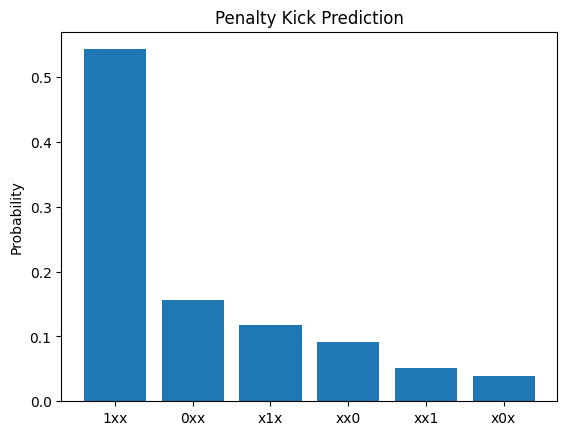

In [ ]:
preds = predict_video("son.mp4")
show_prediction_chart(preds)

In [ ]:
# Colab-ready setup
import cv2, os, numpy as np
from google.colab import files
from google.colab.patches import cv2_imshow

def parse_probs(s):
    parts = [float(x.strip()) for x in s.split(",")]
    if len(parts) != 3:
        raise ValueError("Expected three probabilities: left,mid,right")
    arr = np.array(parts, dtype=np.float32)
    total = float(arr.sum())
    if total <= 0:
        raise ValueError("Probabilities must sum to > 0")
    return arr / total

def get_last_frame_bgr(src_path):
    """If src is image → load; if video → return last frame (BGR)."""
    img = cv2.imread(src_path, cv2.IMREAD_COLOR)
    if img is not None:
        return img

    cap = cv2.VideoCapture(src_path)
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video: {src_path}")

    count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if count > 1:
        cap.set(cv2.CAP_PROP_POS_FRAMES, count - 1)
    ok, frame = cap.read()
    if not ok:
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        last = None
        while True:
            ok, f = cap.read()
            if not ok: break
            last = f
        frame = last
    cap.release()
    if frame is None:
        raise RuntimeError("Failed to read last frame.")
    return frame

def annotate_last_frame(frame_bgr, probs, font=cv2.FONT_HERSHEY_SIMPLEX):
    """Draw Left/Middle/Right boxes with percentages."""
    h, w = frame_bgr.shape[:2]
    y1, y2 = int(0.22*h), int(0.68*h)  # tweak for your camera angle
    thirds = [0, w//3, (2*w)//3, w]
    labels = ["Left", "Middle", "Right"]

    colors = [(60,140,255), (40,220,255), (180,220,255)]  # BGR

    for i, lbl in enumerate(labels):
        x1, x2 = thirds[i], thirds[i+1]
        color = colors[i]
        cv2.rectangle(frame_bgr, (x1+3, y1), (x2-3, y2), color, 3)
        # Title
        (tw, th), _ = cv2.getTextSize(lbl, font, 0.8, 2)
        tx = x1 + (x2-x1)//2 - tw//2
        ty = max(24, y1-10)
        cv2.putText(frame_bgr, lbl, (tx, ty), font, 0.8, (255,255,255), 2, cv2.LINE_AA)
        # Probability
        pct = f"{int(round(float(probs[i]) * 100))}%"
        (pw, ph), _ = cv2.getTextSize(pct, font, 1.0, 2)
        px = x1 + (x2-x1)//2 - pw//2
        py = y1 + (y2-y1)//2 + ph//2
        cv2.putText(frame_bgr, pct, (px, py), font, 1.0, (255,255,255), 2, cv2.LINE_AA)
    return frame_bgr


In [ ]:
uploaded = files.upload()  # choose .png/.jpg/.mp4/.mov etc.
src_path = list(uploaded.keys())[0]
print("Uploaded:", src_path)


Saving son.mp4 to son (1).mp4
Uploaded: son (1).mp4


In [ ]:
def preds_to_score_dict(preds):
    """
    preds: iterable of 3 probability values for [Left, Middle, Right]
    Returns: dict with '100', '010', '001' mapped to their probabilities
    """
    return {
        "100": float(preds[0]),
        "010": float(preds[1]),
        "001": float(preds[2])
    }


Saved: son (1)_annotated.png


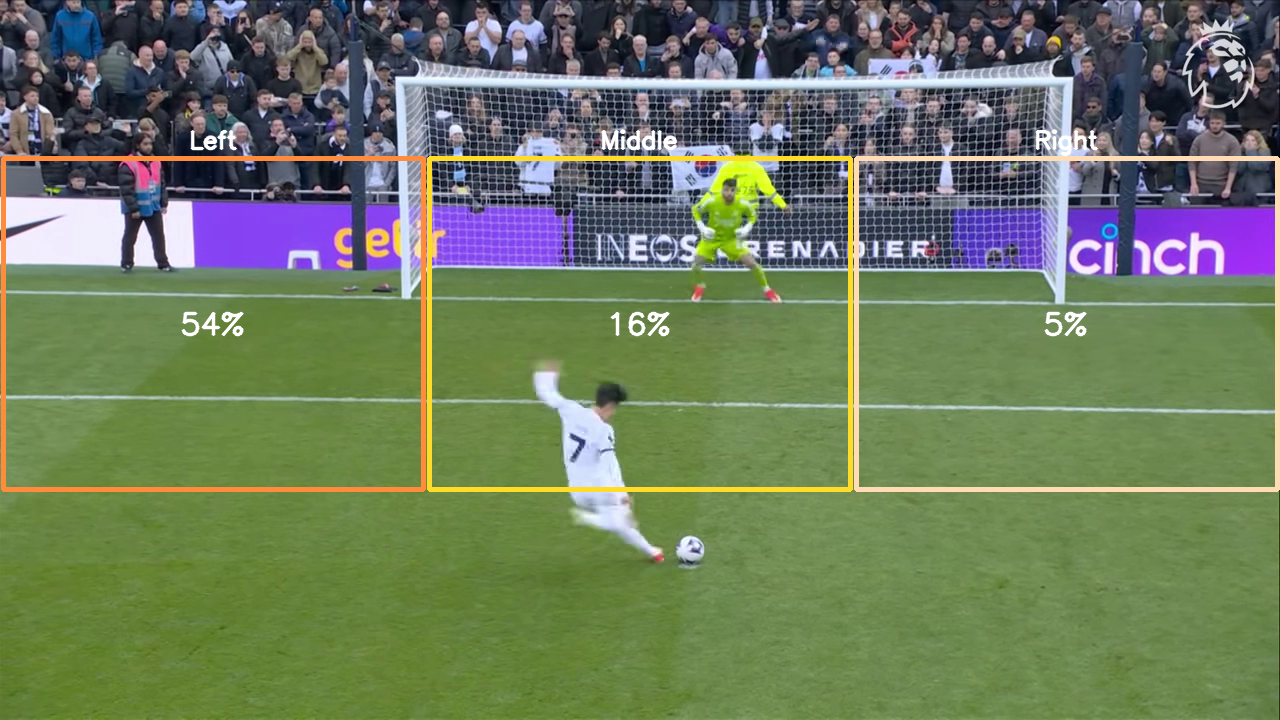

In [ ]:
# Set your probs here as "left,mid,right"
# Access the probabilities from the predict_video function output
# The predict_video function returns a list of tuples [(class_name, probability), ...]
# You need to extract the probabilities for the '1xx', '0xx', and 'xx1' classes
# in the correct order (Left, Middle, Right) based on your CLASS_NAMES mapping.

# Assuming CLASS_NAMES = ['xx1','xx0','1xx','0xx','x1x','x0x']
# And you want Left (1xx), Middle (0xx), Right (xx1) probabilities

# Find the probabilities for Left (1xx), Middle (0xx), Right (xx1)
left_prob = 0.0
middle_prob = 0.0
right_prob = 0.0

for cls, prob in preds:
    if cls == '1xx':
        left_prob = prob
    elif cls == '0xx':
        middle_prob = prob
    elif cls == 'xx1':
        right_prob = prob

# Create a list of probabilities in the order [Left, Middle, Right]
score_probs_list = [left_prob, middle_prob, right_prob]


frame = get_last_frame_bgr(src_path)
annotated = annotate_last_frame(frame.copy(), score_probs_list)

out_path = os.path.splitext(src_path)[0] + "_annotated.png"
cv2.imwrite(out_path, annotated)
print("Saved:", out_path)

# Show in the cell
cv2_imshow(annotated)

In [ ]:
best_model_path = "/content/best_penalty_model (1).pt"  # change to your file path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== 2) Load model ====
model = PenaltyModel(num_classes=6)  # update if num_classes changes
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)

PenaltyModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [ ]:
CLASS_NAMES = ['xx1','xx0','1xx','0xx','x1x','x0x']  # keep in same order as training


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


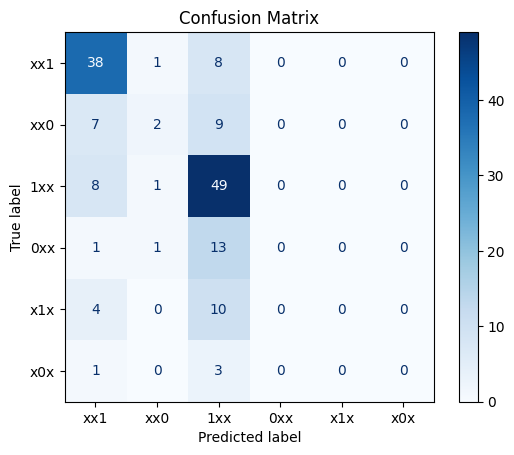

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Ensure the model is in evaluation mode and on the correct device
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

all_labels = []
all_preds = []

with torch.no_grad():
    for crops, lengths, labels in val_loader:
        crops = crops.to(device)
        labels = labels.to(device)
        lengths_cpu = lengths.cpu().long() # Ensure lengths are on CPU and long type

        outputs = model(crops, lengths_cpu)
        preds = outputs.argmax(dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import torch

# ==== 1) Setup ====
best_model_path = "/content/best_penalty_model (1).pt"  # change to your file path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==== 2) Load model ====
model = PenaltyModel(num_classes=6)  # update if num_classes changes
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)

# ==== 3) Evaluate ====
model.eval()
test_correct, test_total = 0, 0

with torch.no_grad():
    for crops, lengths, labels in test_loader:
        crops   = crops.to(device)          # (B, T, C, H, W) or similar
        labels  = labels.to(device)
        # pack_padded_sequence usually wants CPU ints; safest:
        lengths_cpu = lengths.cpu().long()

        outputs = model(crops, lengths_cpu)  # <-- pass lengths
        preds = outputs.argmax(dim=1)
        test_correct += (preds == labels).sum().item()
        test_total   += labels.size(0)

print(f"Test Accuracy: {test_correct/test_total:.4f}")

test_acc = test_correct / test_total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.6076
Test Accuracy: 0.6076
